# Settings

In this notebook we work with the problem of multi-class classification, that is, the correct assignment of an object to one of the classes. Our goal is to achieve high accuracy of assignment to the correct category. We will use the widely used transfer learning method.


Transfer learning is a machine learning technique that uses a pre-trained model. In this approach, a model trained on one data is used or retrained for use with another set of data. By using transfer learning, you can achieve significantly higher classification accuracy, especially when the available data set is limited.

Before running the code, we need to make sure that we are using the GPU. We plan to work with a convolutional neural network, and using a GPU allows us to reduce training time by several times.

In [1]:
# display information about available GPU devices
!nvidia-smi

Sun Jun  8 23:18:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Import libraries

In [2]:
# Visualization purpose
!pip install tensorboardX
!pip install tensorboard
!pip install tensorboard-plugin-customizable-plots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.7 MB/s eta 0:00:00


In [3]:
!pip install split-folders
!pip install optuna
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.1/610.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.0.1
    Uninstalling termcolor-3.0.1:
      Successfully uninstalled termcolor-3.0.1
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.9.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [4]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from codecarbon import EmissionsTracker

/tmp/ipykernel_19/4273075705.py:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2025-06-08 23:18:51.517899: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749424731.740267      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749424731.806472      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import warnings
warnings.filterwarnings('ignore')

# Description of the data set

The dataset contains approximately 12,000 images divided into seven categories of waste, including paper, metal, cardboard, trash, glass, biological, and plastic.


# Data Preprcessing

In [6]:
prepare_data_emission_tracker = EmissionsTracker()
prepare_data_emission_tracker.start()

[codecarbon WARNING @ 23:19:03] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:19:04] [setup] RAM Tracking...
[codecarbon INFO @ 23:19:04] [setup] CPU Tracking...
[codecarbon WARNING @ 23:19:05] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 23:19:05] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 23:19:05] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 23:19:05] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:19:05] [setup] GPU Tracking...
[codecarbon INFO @ 23:19:05] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:19:05] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

In [7]:
data_dir = '/kaggle/input/dwaste-data-v4'

Cleaning the working directory if there are any files in it

In [8]:
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
# os.rmdir(folder_path)

Copying the dataset to the working directory to allow data cleaning

In [9]:
shutil.copytree(data_dir, '/kaggle/working/dataset')

[codecarbon INFO @ 23:19:23] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:19:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:19:23] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 23:19:23] Energy consumed for all GPUs : 0.000080 kWh. Total GPU Power : 19.188096626047223 W
[codecarbon INFO @ 23:19:23] 0.000341 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:19:38] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:19:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:19:38] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 23:19:38] Energy consumed for all GPUs : 0.000160 kWh. Total GPU Power : 19.21753015037541 W
[codecarbon INFO @ 23:19:38] 0.000681 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:19:53] Energy consumed for RAM : 0.000250 kWh. RAM Power : 

'/kaggle/working/dataset'

In [10]:
data_dir  = '/kaggle/working/dataset'

In [11]:
experiment_name = "Transfer Learning"

The Tensorflow library that we are going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [12]:
count=0
image_extensions = [".png", ".jpg"] 
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        if img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)
            count+=1
print(f"Removed {count} images")

/kaggle/working/dataset/plastic/plastic_603.jpg is not an image
/kaggle/working/dataset/plastic/plastic_603.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_2038.jpg is not an image
/kaggle/working/dataset/plastic/plastic_2038.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_613.jpg is not an image
/kaggle/working/dataset/plastic/plastic_613.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/plastic/plastic_160.jpg is not an image
/kaggle/working/dataset/plastic/plastic_160.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2784.jpg is a webp, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_2779.jpg is not an image
/kaggle/working/dataset/paper/paper_2779.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/paper/paper_1433.jpg is not an image
/kaggle/working/dataset/paper/paper_1433.jpg is a None, not accepted by TensorFlow
/kaggle/working/dataset/pap

To train the model, you will need to divide the data into several samples, so we will create folders for them

In [13]:
os.mkdir('data')

In [14]:
os.chdir('data')

In [15]:
os.getcwd()

'/kaggle/working/data'

In [16]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [17]:
os.chdir('/kaggle/working/')

In [18]:
os.getcwd()

'/kaggle/working'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [19]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [20]:
splitfolders.ratio("/kaggle/working/dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 11151 files [00:01, 6538.80 files/s]


In [21]:
data_dir

'/kaggle/working/dataset'

You can now delete the unused dataset folder to save space.

In [22]:
try:
    shutil.rmtree(data_dir)
except OSError as e:
    print("Error: %s : %s" % (data_dir, e.strerror))

Setting paths to training and test data

In [23]:
train_path = '/kaggle/working/data/train'
val_path = '/kaggle/working/data/val'
test_path = '/kaggle/working/data/test'

Visualization of data from a dataset

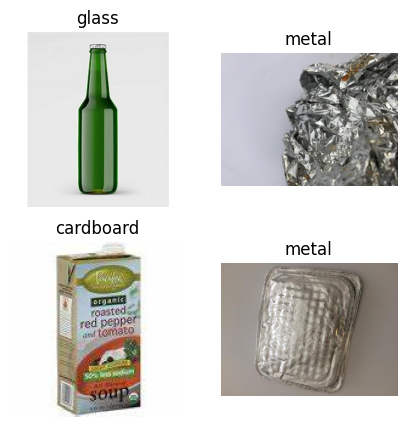

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))  # Display 4 images
axes = axes.ravel()

for i in np.arange(0, 4):
    category = random.choice(os.listdir(train_path))  # Randomly choose a class
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir))  # Randomly choose an image from that class

    img = plt.imread(os.path.join(class_dir, image))
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')


Let's look at the distribution of data between classes.

In [25]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Plastic: 1528
Glass: 2431
Paper: 1315
Metal: 795
Trash: 617
Cardboard: 1446
Biological: 786

Total number of train images: 8918


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [26]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['biological', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [27]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[786, 1446, 2431, 795, 1315, 1528, 617]

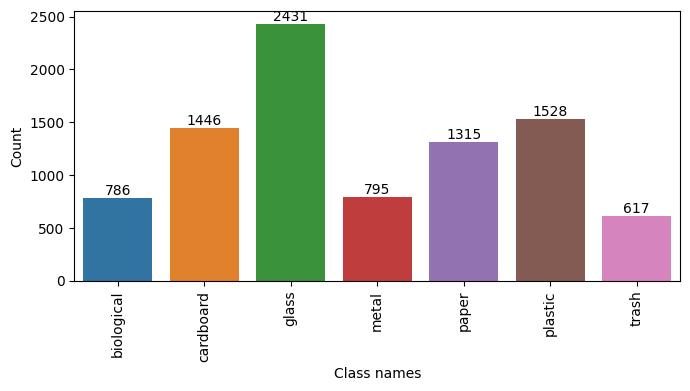

In [28]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

### Class Imbalance in the Dataset

A situation where one or more classes contain a significantly larger number of images is known as **class imbalance**. In our case, this imbalance is expected and reflects the nature of real-world waste distribution. For example:

- **Glass**: 3,039 images  
- **Plastic**: 1,915 images  
- **Cardboard**: 1,810 images  
- **Paper**: 1,650 images  
- **Metal**: 994 images  
- **Biological**: 983 images  
- **Trash**: 772 images  

This imbalance can negatively affect the model’s performance, leading it to favor the larger classes and perform poorly on the underrepresented ones.

To address this issue, we will apply **random undersampling**, a technique that balances the dataset by randomly removing some examples from the overrepresented classes. This helps reduce model bias and improves its ability to generalize across all categories.


Excluding some random images from the training data

In [29]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')


Deleted 528 in plastic


[codecarbon INFO @ 23:20:08] Energy consumed for RAM : 0.000333 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:20:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:20:08] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 23:20:08] Energy consumed for all GPUs : 0.000319 kWh. Total GPU Power : 19.1124157726164 W
[codecarbon INFO @ 23:20:08] 0.001361 kWh of electricity used since the beginning.


Deleted 1431 in glass
Deleted 315 in paper
Deleted 0 in metal
Deleted 0 in trash
Deleted 446 in cardboard
Deleted 0 in biological


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now

In [30]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]

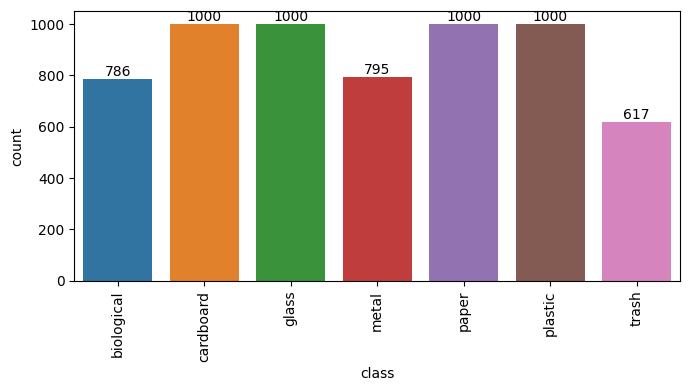

In [31]:
DF = pd.DataFrame(columns=['class','count'])
DF['class']=class_names
DF['count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [32]:
data_path = '/kaggle/working/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [33]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 447.7375
Mean Height: 422.9578


Let's set the size of the input data (image size) taking into account the found average values

In [34]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts

In [35]:
BATCH_SIZE = 32


Create a SummaryWriter instance to write logs

In [36]:
writer = SummaryWriter()

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.


In [37]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 6198 files belonging to 7 classes.


I0000 00:00:1749424810.954336      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749424810.955127      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [38]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 1121 files belonging to 7 classes.


In [39]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 1112 files belonging to 7 classes.


Create directories for train and test logs and write logs to it 

In [40]:
train_log_dir = os.path.join("logs", experiment_name, "train")
test_log_dir = os.path.join("logs", experiment_name, "test")

os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)


In [41]:
prepare_data_emissions: float = prepare_data_emission_tracker.stop()
print(f"Prepare Data Carbon Emissions: {prepare_data_emissions} kg")

[codecarbon INFO @ 23:20:12] Energy consumed for RAM : 0.000358 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:20:12] Delta energy consumed for CPU with constant : 0.000053 kWh, power : 42.5 W
[codecarbon INFO @ 23:20:12] Energy consumed for All CPU : 0.000761 kWh
[codecarbon INFO @ 23:20:12] Energy consumed for all GPUs : 0.000363 kWh. Total GPU Power : 34.92411548223555 W
[codecarbon INFO @ 23:20:12] 0.001482 kWh of electricity used since the beginning.


Prepare Data Carbon Emissions: 0.0006707277716394754 kg


# Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/).
For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the EfficientNetV2M model is selected. Although the EfficientNetV2M and EfficientNetV2L models have higher accuracy, they have significantly higher weights.


In [42]:
develop_model_emission_tracker = EmissionsTracker()
develop_model_emission_tracker.start()

[codecarbon WARNING @ 23:20:13] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:20:13] [setup] RAM Tracking...
[codecarbon INFO @ 23:20:13] [setup] CPU Tracking...
[codecarbon WARNING @ 23:20:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 23:20:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 23:20:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 23:20:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:20:14] [setup] GPU Tracking...
[codecarbon INFO @ 23:20:14] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 23:20:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Loading the model

In [43]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Let's see what the architecture of the pretrained model looks like

In [44]:
base_model.summary()

Model: "efficientnetv2-m"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 400, 400, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 400, 400, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 200, 200, 24)   │            648 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 200, 200, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 200, 200, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 200, 200, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 200, 200, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 200, 200, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 200, 200, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 200, 200, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 200, 200, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 200, 200, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 200, 200, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 200, 200, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1c_project_conv 

 Total params: 53,150,388 (202.75 MB)

 Trainable params: 52,858,356 (201.64 MB)

 Non-trainable params: 292,032 (1.11 MB)

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.ь.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [45]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [46]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

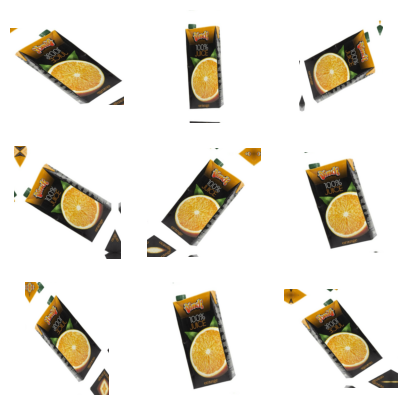

In [47]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

* GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
* A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
* Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [48]:
name="EfficientNetV2M"

EfficientNetV2M_model=tf.keras.Sequential([tf.keras.Input(shape=(None, None, 3), name="input_layer"),
                    data_augmentation,
                    base_model,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(len(class_names), activation='softmax')
                    ], name=name)

For training, we will define a loss function, an optimizer, and a tracked accuracy metric

In [49]:
EfficientNetV2M_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model

In [50]:
EfficientNetV2M_model.summary()

Model: "EfficientNetV2M"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, None, None, 1280)    │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,315,259 (203.38 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [51]:
# def log_to_tensorboard(epoch, logs):
#         train_writer.add_scalar('loss', logs['loss'], epoch)
#         train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
#         test_writer.add_scalar('val_loss', logs['val_loss'], epoch)
#         test_writer.add_scalar('val_accuracy', logs['val_accuracy'], epoch)
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [52]:
EfficientNetV2M_callback = create_callback(name)

Let's set the number of training epochs

In [53]:
EPOCH=20

Let's train the model

In [54]:
import time
start_time = time.time()
EfficientNetV2M_history = EfficientNetV2M_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=EfficientNetV2M_callback)

Epoch 1/20


[codecarbon INFO @ 23:20:32] Energy consumed for RAM : 0.000083 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:20:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:20:32] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 23:20:32] Energy consumed for all GPUs : 0.000222 kWh. Total GPU Power : 53.24440402372369 W
[codecarbon INFO @ 23:20:32] 0.000483 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:20:47] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:20:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:20:47] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 23:20:47] Energy consumed for all GPUs : 0.000447 kWh. Total GPU Power : 53.84473598373228 W
[codecarbon INFO @ 23:20:47] 0.000968 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:21:02] Energy consumed for RAM : 0.000249 kWh. RAM Power : 2

 10/194 ━━━━━━━━━━━━━━━━━━━━ 4:15 1s/step - accuracy: 0.3076 - loss: 1.7614

[codecarbon INFO @ 23:21:32] Energy consumed for RAM : 0.000416 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:21:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:21:32] Energy consumed for All CPU : 0.000884 kWh
[codecarbon INFO @ 23:21:32] Energy consumed for all GPUs : 0.001307 kWh. Total GPU Power : 94.27469673290823 W
[codecarbon INFO @ 23:21:32] 0.002607 kWh of electricity used since the beginning.


 20/194 ━━━━━━━━━━━━━━━━━━━━ 4:22 2s/step - accuracy: 0.4054 - loss: 1.6141

[codecarbon INFO @ 23:21:47] Energy consumed for RAM : 0.000499 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:21:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:21:47] Energy consumed for All CPU : 0.001061 kWh
[codecarbon INFO @ 23:21:47] Energy consumed for all GPUs : 0.001702 kWh. Total GPU Power : 94.89790164126195 W
[codecarbon INFO @ 23:21:47] 0.003262 kWh of electricity used since the beginning.


 30/194 ━━━━━━━━━━━━━━━━━━━━ 4:08 2s/step - accuracy: 0.4677 - loss: 1.4948

[codecarbon INFO @ 23:22:02] Energy consumed for RAM : 0.000582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:22:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:22:02] Energy consumed for All CPU : 0.001238 kWh
[codecarbon INFO @ 23:22:02] Energy consumed for all GPUs : 0.002097 kWh. Total GPU Power : 94.66801728536898 W
[codecarbon INFO @ 23:22:02] 0.003917 kWh of electricity used since the beginning.


 39/194 ━━━━━━━━━━━━━━━━━━━━ 3:57 2s/step - accuracy: 0.5111 - loss: 1.4046

[codecarbon INFO @ 23:22:17] Energy consumed for RAM : 0.000666 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:22:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:22:17] Energy consumed for All CPU : 0.001415 kWh
[codecarbon INFO @ 23:22:17] Energy consumed for all GPUs : 0.002491 kWh. Total GPU Power : 94.58146533692835 W
[codecarbon INFO @ 23:22:17] 0.004571 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:22:17] 0.017239 g.CO2eq/s mean an estimation of 543.6387716370945 kg.CO2eq/year


 48/194 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.5443 - loss: 1.3296

[codecarbon INFO @ 23:22:32] Energy consumed for RAM : 0.000749 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:22:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:22:32] Energy consumed for All CPU : 0.001592 kWh
[codecarbon INFO @ 23:22:32] Energy consumed for all GPUs : 0.002885 kWh. Total GPU Power : 94.55901465210451 W
[codecarbon INFO @ 23:22:32] 0.005225 kWh of electricity used since the beginning.


 57/194 ━━━━━━━━━━━━━━━━━━━━ 3:36 2s/step - accuracy: 0.5711 - loss: 1.2652

[codecarbon INFO @ 23:22:47] Energy consumed for RAM : 0.000832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:22:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:22:47] Energy consumed for All CPU : 0.001769 kWh
[codecarbon INFO @ 23:22:47] Energy consumed for all GPUs : 0.003276 kWh. Total GPU Power : 94.10143748507267 W
[codecarbon INFO @ 23:22:47] 0.005878 kWh of electricity used since the beginning.


 65/194 ━━━━━━━━━━━━━━━━━━━━ 3:28 2s/step - accuracy: 0.5910 - loss: 1.2159

[codecarbon INFO @ 23:23:02] Energy consumed for RAM : 0.000916 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:23:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:23:02] Energy consumed for All CPU : 0.001946 kWh
[codecarbon INFO @ 23:23:02] Energy consumed for all GPUs : 0.003669 kWh. Total GPU Power : 94.30473935217131 W
[codecarbon INFO @ 23:23:02] 0.006531 kWh of electricity used since the beginning.


 74/194 ━━━━━━━━━━━━━━━━━━━━ 3:14 2s/step - accuracy: 0.6100 - loss: 1.1670

[codecarbon INFO @ 23:23:17] Energy consumed for RAM : 0.000999 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:23:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:23:17] Energy consumed for All CPU : 0.002123 kWh
[codecarbon INFO @ 23:23:17] Energy consumed for all GPUs : 0.004061 kWh. Total GPU Power : 94.02550046163613 W
[codecarbon INFO @ 23:23:17] 0.007183 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.6244 - loss: 1.1295

[codecarbon INFO @ 23:23:32] Energy consumed for RAM : 0.001082 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:23:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:23:32] Energy consumed for All CPU : 0.002300 kWh
[codecarbon INFO @ 23:23:32] Energy consumed for all GPUs : 0.004453 kWh. Total GPU Power : 94.13603697902622 W
[codecarbon INFO @ 23:23:32] 0.007835 kWh of electricity used since the beginning.


 90/194 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.6371 - loss: 1.0958

[codecarbon INFO @ 23:23:47] Energy consumed for RAM : 0.001165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:23:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:23:47] Energy consumed for All CPU : 0.002477 kWh
[codecarbon INFO @ 23:23:47] Energy consumed for all GPUs : 0.004844 kWh. Total GPU Power : 93.86880789541331 W
[codecarbon INFO @ 23:23:47] 0.008486 kWh of electricity used since the beginning.


 99/194 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.6494 - loss: 1.0621

[codecarbon INFO @ 23:24:02] Energy consumed for RAM : 0.001249 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:24:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:24:02] Energy consumed for All CPU : 0.002654 kWh
[codecarbon INFO @ 23:24:02] Energy consumed for all GPUs : 0.005235 kWh. Total GPU Power : 93.8354923006876 W
[codecarbon INFO @ 23:24:02] 0.009137 kWh of electricity used since the beginning.


107/194 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.6591 - loss: 1.0355

[codecarbon INFO @ 23:24:17] Energy consumed for RAM : 0.001332 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:24:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:24:17] Energy consumed for All CPU : 0.002831 kWh
[codecarbon INFO @ 23:24:17] Energy consumed for all GPUs : 0.005627 kWh. Total GPU Power : 94.17056559823762 W
[codecarbon INFO @ 23:24:17] 0.009790 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:24:17] 0.019682 g.CO2eq/s mean an estimation of 620.6977283092522 kg.CO2eq/year


117/194 ━━━━━━━━━━━━━━━━━━━━ 2:08 2s/step - accuracy: 0.6697 - loss: 1.0059

[codecarbon INFO @ 23:24:32] Energy consumed for RAM : 0.001415 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:24:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:24:32] Energy consumed for All CPU : 0.003008 kWh
[codecarbon INFO @ 23:24:32] Energy consumed for all GPUs : 0.006017 kWh. Total GPU Power : 93.736934293553 W
[codecarbon INFO @ 23:24:32] 0.010440 kWh of electricity used since the beginning.


125/194 ━━━━━━━━━━━━━━━━━━━━ 1:56 2s/step - accuracy: 0.6773 - loss: 0.9842

[codecarbon INFO @ 23:24:47] Energy consumed for RAM : 0.001498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:24:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:24:47] Energy consumed for All CPU : 0.003185 kWh
[codecarbon INFO @ 23:24:47] Energy consumed for all GPUs : 0.006408 kWh. Total GPU Power : 93.91246010211671 W
[codecarbon INFO @ 23:24:47] 0.011092 kWh of electricity used since the beginning.


133/194 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.6844 - loss: 0.9643

[codecarbon INFO @ 23:25:02] Energy consumed for RAM : 0.001582 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:25:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:25:02] Energy consumed for All CPU : 0.003362 kWh
[codecarbon INFO @ 23:25:02] Energy consumed for all GPUs : 0.006798 kWh. Total GPU Power : 93.59835167020238 W
[codecarbon INFO @ 23:25:02] 0.011742 kWh of electricity used since the beginning.


142/194 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.6918 - loss: 0.9433

[codecarbon INFO @ 23:25:17] Energy consumed for RAM : 0.001665 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:25:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:25:17] Energy consumed for All CPU : 0.003539 kWh
[codecarbon INFO @ 23:25:17] Energy consumed for all GPUs : 0.007188 kWh. Total GPU Power : 93.59820053022732 W
[codecarbon INFO @ 23:25:17] 0.012392 kWh of electricity used since the beginning.


150/194 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.6978 - loss: 0.9260

[codecarbon INFO @ 23:25:32] Energy consumed for RAM : 0.001748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:25:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:25:32] Energy consumed for All CPU : 0.003716 kWh
[codecarbon INFO @ 23:25:32] Energy consumed for all GPUs : 0.007579 kWh. Total GPU Power : 93.92387318420467 W
[codecarbon INFO @ 23:25:32] 0.013043 kWh of electricity used since the beginning.


160/194 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.7048 - loss: 0.9059

[codecarbon INFO @ 23:25:47] Energy consumed for RAM : 0.001832 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:25:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:25:47] Energy consumed for All CPU : 0.003893 kWh
[codecarbon INFO @ 23:25:47] Energy consumed for all GPUs : 0.007969 kWh. Total GPU Power : 93.49554140636317 W
[codecarbon INFO @ 23:25:47] 0.013693 kWh of electricity used since the beginning.


169/194 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7106 - loss: 0.8891

[codecarbon INFO @ 23:26:02] Energy consumed for RAM : 0.001915 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:26:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:26:02] Energy consumed for All CPU : 0.004070 kWh
[codecarbon INFO @ 23:26:02] Energy consumed for all GPUs : 0.008359 kWh. Total GPU Power : 93.77245717532429 W
[codecarbon INFO @ 23:26:02] 0.014344 kWh of electricity used since the beginning.


178/194 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7158 - loss: 0.8737

[codecarbon INFO @ 23:26:17] Energy consumed for RAM : 0.001998 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:26:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:26:17] Energy consumed for All CPU : 0.004247 kWh
[codecarbon INFO @ 23:26:17] Energy consumed for all GPUs : 0.008748 kWh. Total GPU Power : 93.47072991279062 W
[codecarbon INFO @ 23:26:17] 0.014993 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:26:17] 0.019627 g.CO2eq/s mean an estimation of 618.9498869574694 kg.CO2eq/year


186/194 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7202 - loss: 0.8607

[codecarbon INFO @ 23:26:32] Energy consumed for RAM : 0.002081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:26:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:26:32] Energy consumed for All CPU : 0.004424 kWh


187/194 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7207 - loss: 0.8592

[codecarbon INFO @ 23:26:32] Energy consumed for all GPUs : 0.009138 kWh. Total GPU Power : 93.5822178918558 W
[codecarbon INFO @ 23:26:32] 0.015643 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7243 - loss: 0.8487

[codecarbon INFO @ 23:26:47] Energy consumed for RAM : 0.002165 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:26:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:26:47] Energy consumed for All CPU : 0.004601 kWh
[codecarbon INFO @ 23:26:47] Energy consumed for all GPUs : 0.009507 kWh. Total GPU Power : 88.59543875131257 W
[codecarbon INFO @ 23:26:47] 0.016273 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:02] Energy consumed for RAM : 0.002248 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:27:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:27:02] Energy consumed for All CPU : 0.004778 kWh
[codecarbon INFO @ 23:27:02] Energy consumed for all GPUs : 0.009814 kWh. Total GPU Power : 73.62976669279466 W
[codecarbon INFO @ 23:27:02] 0.016839 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:27:17] Energy consumed for RAM : 0.002331 kWh. RAM Power : 2

194/194 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - accuracy: 0.7247 - loss: 0.8472 - val_accuracy: 0.9137 - val_loss: 0.2566 - learning_rate: 0.0010
Epoch 2/20
  1/194 ━━━━━━━━━━━━━━━━━━━━ 5:05 2s/step - accuracy: 0.7812 - loss: 0.6610

[codecarbon INFO @ 23:27:32] Energy consumed for RAM : 0.002414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:27:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:27:32] Energy consumed for All CPU : 0.005132 kWh
[codecarbon INFO @ 23:27:32] Energy consumed for all GPUs : 0.010586 kWh. Total GPU Power : 91.67784046135284 W
[codecarbon INFO @ 23:27:32] 0.018132 kWh of electricity used since the beginning.


  9/194 ━━━━━━━━━━━━━━━━━━━━ 6:08 2s/step - accuracy: 0.8631 - loss: 0.4341

[codecarbon INFO @ 23:27:47] Energy consumed for RAM : 0.002498 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:27:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:27:47] Energy consumed for All CPU : 0.005309 kWh
[codecarbon INFO @ 23:27:47] Energy consumed for all GPUs : 0.010976 kWh. Total GPU Power : 93.64413443630785 W
[codecarbon INFO @ 23:27:47] 0.018782 kWh of electricity used since the beginning.


 17/194 ━━━━━━━━━━━━━━━━━━━━ 5:31 2s/step - accuracy: 0.8748 - loss: 0.4019

[codecarbon INFO @ 23:28:02] Energy consumed for RAM : 0.002581 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:28:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:28:02] Energy consumed for All CPU : 0.005486 kWh
[codecarbon INFO @ 23:28:02] Energy consumed for all GPUs : 0.011367 kWh. Total GPU Power : 93.90567780878577 W
[codecarbon INFO @ 23:28:02] 0.019434 kWh of electricity used since the beginning.


 27/194 ━━━━━━━━━━━━━━━━━━━━ 4:54 2s/step - accuracy: 0.8772 - loss: 0.3926

[codecarbon INFO @ 23:28:17] Energy consumed for RAM : 0.002664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:28:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:28:17] Energy consumed for All CPU : 0.005663 kWh
[codecarbon INFO @ 23:28:17] Energy consumed for all GPUs : 0.011757 kWh. Total GPU Power : 93.5262845773908 W
[codecarbon INFO @ 23:28:17] 0.020084 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:28:17] 0.019199 g.CO2eq/s mean an estimation of 605.4716654060145 kg.CO2eq/year


 36/194 ━━━━━━━━━━━━━━━━━━━━ 4:32 2s/step - accuracy: 0.8786 - loss: 0.3861

[codecarbon INFO @ 23:28:32] Energy consumed for RAM : 0.002748 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:28:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:28:32] Energy consumed for All CPU : 0.005840 kWh
[codecarbon INFO @ 23:28:32] Energy consumed for all GPUs : 0.012147 kWh. Total GPU Power : 93.76896540773336 W
[codecarbon INFO @ 23:28:32] 0.020734 kWh of electricity used since the beginning.


 45/194 ━━━━━━━━━━━━━━━━━━━━ 4:18 2s/step - accuracy: 0.8795 - loss: 0.3805

[codecarbon INFO @ 23:28:47] Energy consumed for RAM : 0.002831 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:28:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:28:47] Energy consumed for All CPU : 0.006017 kWh
[codecarbon INFO @ 23:28:47] Energy consumed for all GPUs : 0.012537 kWh. Total GPU Power : 93.58137134016646 W
[codecarbon INFO @ 23:28:47] 0.021385 kWh of electricity used since the beginning.


 54/194 ━━━━━━━━━━━━━━━━━━━━ 4:01 2s/step - accuracy: 0.8798 - loss: 0.3763

[codecarbon INFO @ 23:29:02] Energy consumed for RAM : 0.002914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:29:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:29:02] Energy consumed for All CPU : 0.006193 kWh
[codecarbon INFO @ 23:29:02] Energy consumed for all GPUs : 0.012925 kWh. Total GPU Power : 93.22878384528792 W
[codecarbon INFO @ 23:29:02] 0.022033 kWh of electricity used since the beginning.


 63/194 ━━━━━━━━━━━━━━━━━━━━ 3:41 2s/step - accuracy: 0.8799 - loss: 0.3728

[codecarbon INFO @ 23:29:17] Energy consumed for RAM : 0.002997 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:29:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:29:17] Energy consumed for All CPU : 0.006370 kWh
[codecarbon INFO @ 23:29:17] Energy consumed for all GPUs : 0.013316 kWh. Total GPU Power : 93.87527716920535 W
[codecarbon INFO @ 23:29:17] 0.022684 kWh of electricity used since the beginning.


 72/194 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.8802 - loss: 0.3695

[codecarbon INFO @ 23:29:32] Energy consumed for RAM : 0.003081 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:29:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:29:32] Energy consumed for All CPU : 0.006548 kWh
[codecarbon INFO @ 23:29:32] Energy consumed for all GPUs : 0.013706 kWh. Total GPU Power : 93.44700414837011 W
[codecarbon INFO @ 23:29:32] 0.023334 kWh of electricity used since the beginning.


 82/194 ━━━━━━━━━━━━━━━━━━━━ 3:07 2s/step - accuracy: 0.8808 - loss: 0.3660

[codecarbon INFO @ 23:29:47] Energy consumed for RAM : 0.003164 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:29:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:29:47] Energy consumed for All CPU : 0.006724 kWh
[codecarbon INFO @ 23:29:47] Energy consumed for all GPUs : 0.014096 kWh. Total GPU Power : 93.78027981288548 W
[codecarbon INFO @ 23:29:47] 0.023984 kWh of electricity used since the beginning.


 90/194 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.8811 - loss: 0.3638

[codecarbon INFO @ 23:30:02] Energy consumed for RAM : 0.003247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:30:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:30:02] Energy consumed for All CPU : 0.006901 kWh
[codecarbon INFO @ 23:30:02] Energy consumed for all GPUs : 0.014486 kWh. Total GPU Power : 93.5276071797075 W
[codecarbon INFO @ 23:30:02] 0.024634 kWh of electricity used since the beginning.


 99/194 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.8812 - loss: 0.3623

[codecarbon INFO @ 23:30:17] Energy consumed for RAM : 0.003331 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:30:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:30:17] Energy consumed for All CPU : 0.007078 kWh
[codecarbon INFO @ 23:30:17] Energy consumed for all GPUs : 0.014876 kWh. Total GPU Power : 93.64406368953469 W
[codecarbon INFO @ 23:30:17] 0.025285 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:30:17] 0.019617 g.CO2eq/s mean an estimation of 618.6387872266822 kg.CO2eq/year


108/194 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.8812 - loss: 0.3611

[codecarbon INFO @ 23:30:32] Energy consumed for RAM : 0.003414 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:30:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:30:32] Energy consumed for All CPU : 0.007255 kWh
[codecarbon INFO @ 23:30:32] Energy consumed for all GPUs : 0.015265 kWh. Total GPU Power : 93.37165881210203 W
[codecarbon INFO @ 23:30:32] 0.025934 kWh of electricity used since the beginning.


118/194 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.8812 - loss: 0.3599

[codecarbon INFO @ 23:30:47] Energy consumed for RAM : 0.003497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:30:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:30:47] Energy consumed for All CPU : 0.007432 kWh
[codecarbon INFO @ 23:30:47] Energy consumed for all GPUs : 0.015653 kWh. Total GPU Power : 93.37106464967084 W
[codecarbon INFO @ 23:30:47] 0.026583 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - accuracy: 0.8813 - loss: 0.3588

[codecarbon INFO @ 23:31:02] Energy consumed for RAM : 0.003580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:31:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:31:02] Energy consumed for All CPU : 0.007609 kWh
[codecarbon INFO @ 23:31:02] Energy consumed for all GPUs : 0.016044 kWh. Total GPU Power : 93.77143689010919 W
[codecarbon INFO @ 23:31:02] 0.027234 kWh of electricity used since the beginning.


136/194 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - accuracy: 0.8815 - loss: 0.3575

[codecarbon INFO @ 23:31:17] Energy consumed for RAM : 0.003664 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:31:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:31:17] Energy consumed for All CPU : 0.007786 kWh
[codecarbon INFO @ 23:31:17] Energy consumed for all GPUs : 0.016433 kWh. Total GPU Power : 93.34875080858873 W
[codecarbon INFO @ 23:31:17] 0.027883 kWh of electricity used since the beginning.


144/194 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.8817 - loss: 0.3565

[codecarbon INFO @ 23:31:32] Energy consumed for RAM : 0.003747 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:31:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:31:32] Energy consumed for All CPU : 0.007963 kWh
[codecarbon INFO @ 23:31:32] Energy consumed for all GPUs : 0.016823 kWh. Total GPU Power : 93.69567115300248 W
[codecarbon INFO @ 23:31:32] 0.028534 kWh of electricity used since the beginning.


153/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.8820 - loss: 0.3554

[codecarbon INFO @ 23:31:47] Energy consumed for RAM : 0.003830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:31:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:31:47] Energy consumed for All CPU : 0.008140 kWh
[codecarbon INFO @ 23:31:47] Energy consumed for all GPUs : 0.017212 kWh. Total GPU Power : 93.42320781301166 W
[codecarbon INFO @ 23:31:47] 0.029183 kWh of electricity used since the beginning.


162/194 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.8822 - loss: 0.3543

[codecarbon INFO @ 23:32:02] Energy consumed for RAM : 0.003914 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:32:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:32:02] Energy consumed for All CPU : 0.008317 kWh
[codecarbon INFO @ 23:32:02] Energy consumed for all GPUs : 0.017600 kWh. Total GPU Power : 93.26276961072185 W
[codecarbon INFO @ 23:32:02] 0.029831 kWh of electricity used since the beginning.


171/194 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8825 - loss: 0.3532

[codecarbon INFO @ 23:32:17] Energy consumed for RAM : 0.003997 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:32:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:32:17] Energy consumed for All CPU : 0.008494 kWh
[codecarbon INFO @ 23:32:17] Energy consumed for all GPUs : 0.017992 kWh. Total GPU Power : 93.95840344488677 W
[codecarbon INFO @ 23:32:17] 0.030483 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:32:17] 0.019607 g.CO2eq/s mean an estimation of 618.3131905425867 kg.CO2eq/year


180/194 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8826 - loss: 0.3525

[codecarbon INFO @ 23:32:32] Energy consumed for RAM : 0.004080 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:32:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:32:32] Energy consumed for All CPU : 0.008671 kWh
[codecarbon INFO @ 23:32:32] Energy consumed for all GPUs : 0.018381 kWh. Total GPU Power : 93.38607013385415 W
[codecarbon INFO @ 23:32:32] 0.031132 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8828 - loss: 0.3517 

[codecarbon INFO @ 23:32:47] Energy consumed for RAM : 0.004163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:32:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:32:47] Energy consumed for All CPU : 0.008848 kWh
[codecarbon INFO @ 23:32:47] Energy consumed for all GPUs : 0.018771 kWh. Total GPU Power : 93.59870370677021 W
[codecarbon INFO @ 23:32:47] 0.031782 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8829 - loss: 0.3512

[codecarbon INFO @ 23:33:02] Energy consumed for RAM : 0.004247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:33:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:33:02] Energy consumed for All CPU : 0.009025 kWh
[codecarbon INFO @ 23:33:02] Energy consumed for all GPUs : 0.019158 kWh. Total GPU Power : 93.07687915082936 W
[codecarbon INFO @ 23:33:02] 0.032430 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:33:17] Energy consumed for RAM : 0.004330 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:33:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:33:17] Energy consumed for All CPU : 0.009202 kWh
[codecarbon INFO @ 23:33:17] Energy consumed for all GPUs : 0.019547 kWh. Total GPU Power : 93.35187693009168 W
[codecarbon INFO @ 23:33:17] 0.033079 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.8830 - loss: 0.3511 - val_accuracy: 0.9236 - val_loss: 0.2248 - learning_rate: 0.0010
Epoch 3/20
  6/194 ━━━━━━━━━━━━━━━━━━━━ 5:04 2s/step - accuracy: 0.9360 - loss: 0.1955

[codecarbon INFO @ 23:33:32] Energy consumed for RAM : 0.004413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:33:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:33:32] Energy consumed for All CPU : 0.009379 kWh
[codecarbon INFO @ 23:33:32] Energy consumed for all GPUs : 0.019929 kWh. Total GPU Power : 91.73445973438649 W
[codecarbon INFO @ 23:33:32] 0.033722 kWh of electricity used since the beginning.


 15/194 ━━━━━━━━━━━━━━━━━━━━ 4:45 2s/step - accuracy: 0.9285 - loss: 0.2221

[codecarbon INFO @ 23:33:47] Energy consumed for RAM : 0.004497 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:33:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:33:47] Energy consumed for All CPU : 0.009556 kWh
[codecarbon INFO @ 23:33:47] Energy consumed for all GPUs : 0.020318 kWh. Total GPU Power : 93.40753683144284 W
[codecarbon INFO @ 23:33:47] 0.034371 kWh of electricity used since the beginning.


 23/194 ━━━━━━━━━━━━━━━━━━━━ 4:41 2s/step - accuracy: 0.9260 - loss: 0.2352

[codecarbon INFO @ 23:34:02] Energy consumed for RAM : 0.004580 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:34:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:34:02] Energy consumed for All CPU : 0.009733 kWh
[codecarbon INFO @ 23:34:02] Energy consumed for all GPUs : 0.020708 kWh. Total GPU Power : 93.6912207965423 W
[codecarbon INFO @ 23:34:02] 0.035021 kWh of electricity used since the beginning.


 33/194 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.9222 - loss: 0.2511

[codecarbon INFO @ 23:34:17] Energy consumed for RAM : 0.004663 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:34:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:34:17] Energy consumed for All CPU : 0.009910 kWh
[codecarbon INFO @ 23:34:17] Energy consumed for all GPUs : 0.021097 kWh. Total GPU Power : 93.40700417543027 W
[codecarbon INFO @ 23:34:17] 0.035671 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:34:17] 0.019566 g.CO2eq/s mean an estimation of 617.0461339083114 kg.CO2eq/year


 42/194 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.9196 - loss: 0.2590

[codecarbon INFO @ 23:34:32] Energy consumed for RAM : 0.004746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:34:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:34:32] Energy consumed for All CPU : 0.010087 kWh
[codecarbon INFO @ 23:34:32] Energy consumed for all GPUs : 0.021488 kWh. Total GPU Power : 93.76624203188352 W
[codecarbon INFO @ 23:34:32] 0.036321 kWh of electricity used since the beginning.


 52/194 ━━━━━━━━━━━━━━━━━━━━ 3:48 2s/step - accuracy: 0.9174 - loss: 0.2648

[codecarbon INFO @ 23:34:47] Energy consumed for RAM : 0.004830 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:34:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:34:47] Energy consumed for All CPU : 0.010264 kWh
[codecarbon INFO @ 23:34:47] Energy consumed for all GPUs : 0.021876 kWh. Total GPU Power : 93.29999301592429 W
[codecarbon INFO @ 23:34:47] 0.036970 kWh of electricity used since the beginning.


 63/194 ━━━━━━━━━━━━━━━━━━━━ 3:27 2s/step - accuracy: 0.9161 - loss: 0.2681

[codecarbon INFO @ 23:35:02] Energy consumed for RAM : 0.004913 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:35:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:35:02] Energy consumed for All CPU : 0.010441 kWh
[codecarbon INFO @ 23:35:02] Energy consumed for all GPUs : 0.022267 kWh. Total GPU Power : 93.72108022433589 W
[codecarbon INFO @ 23:35:02] 0.037621 kWh of electricity used since the beginning.


 73/194 ━━━━━━━━━━━━━━━━━━━━ 3:10 2s/step - accuracy: 0.9150 - loss: 0.2709

[codecarbon INFO @ 23:35:17] Energy consumed for RAM : 0.004996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:35:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:35:17] Energy consumed for All CPU : 0.010618 kWh
[codecarbon INFO @ 23:35:17] Energy consumed for all GPUs : 0.022655 kWh. Total GPU Power : 93.24795565574091 W
[codecarbon INFO @ 23:35:17] 0.038270 kWh of electricity used since the beginning.


 84/194 ━━━━━━━━━━━━━━━━━━━━ 2:49 2s/step - accuracy: 0.9140 - loss: 0.2734

[codecarbon INFO @ 23:35:32] Energy consumed for RAM : 0.005079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:35:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:35:32] Energy consumed for All CPU : 0.010795 kWh
[codecarbon INFO @ 23:35:32] Energy consumed for all GPUs : 0.023044 kWh. Total GPU Power : 93.43420994005758 W
[codecarbon INFO @ 23:35:32] 0.038919 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 2:39 2s/step - accuracy: 0.9134 - loss: 0.2748

[codecarbon INFO @ 23:35:47] Energy consumed for RAM : 0.005163 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:35:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:35:47] Energy consumed for All CPU : 0.010972 kWh
[codecarbon INFO @ 23:35:47] Energy consumed for all GPUs : 0.023434 kWh. Total GPU Power : 93.68165234949102 W
[codecarbon INFO @ 23:35:47] 0.039569 kWh of electricity used since the beginning.


102/194 ━━━━━━━━━━━━━━━━━━━━ 2:23 2s/step - accuracy: 0.9128 - loss: 0.2764

[codecarbon INFO @ 23:36:02] Energy consumed for RAM : 0.005246 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:36:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:36:02] Energy consumed for All CPU : 0.011149 kWh
[codecarbon INFO @ 23:36:02] Energy consumed for all GPUs : 0.023823 kWh. Total GPU Power : 93.39535139213132 W
[codecarbon INFO @ 23:36:02] 0.040218 kWh of electricity used since the beginning.


112/194 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.9125 - loss: 0.2777

[codecarbon INFO @ 23:36:17] Energy consumed for RAM : 0.005329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:36:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:36:17] Energy consumed for All CPU : 0.011326 kWh
[codecarbon INFO @ 23:36:17] Energy consumed for all GPUs : 0.024213 kWh. Total GPU Power : 93.61515497115393 W
[codecarbon INFO @ 23:36:17] 0.040869 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:36:17] 0.019606 g.CO2eq/s mean an estimation of 618.2797857601279 kg.CO2eq/year


121/194 ━━━━━━━━━━━━━━━━━━━━ 1:53 2s/step - accuracy: 0.9121 - loss: 0.2787

[codecarbon INFO @ 23:36:32] Energy consumed for RAM : 0.005413 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:36:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:36:32] Energy consumed for All CPU : 0.011503 kWh
[codecarbon INFO @ 23:36:32] Energy consumed for all GPUs : 0.024602 kWh. Total GPU Power : 93.39486708304489 W
[codecarbon INFO @ 23:36:32] 0.041518 kWh of electricity used since the beginning.


131/194 ━━━━━━━━━━━━━━━━━━━━ 1:38 2s/step - accuracy: 0.9117 - loss: 0.2796

[codecarbon INFO @ 23:36:47] Energy consumed for RAM : 0.005496 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:36:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:36:47] Energy consumed for All CPU : 0.011680 kWh
[codecarbon INFO @ 23:36:47] Energy consumed for all GPUs : 0.024991 kWh. Total GPU Power : 93.22271243583558 W
[codecarbon INFO @ 23:36:47] 0.042167 kWh of electricity used since the beginning.


141/194 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.9115 - loss: 0.2804

[codecarbon INFO @ 23:37:02] Energy consumed for RAM : 0.005579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:37:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:37:02] Energy consumed for All CPU : 0.011857 kWh
[codecarbon INFO @ 23:37:02] Energy consumed for all GPUs : 0.025381 kWh. Total GPU Power : 93.73152433940787 W
[codecarbon INFO @ 23:37:02] 0.042817 kWh of electricity used since the beginning.


150/194 ━━━━━━━━━━━━━━━━━━━━ 1:08 2s/step - accuracy: 0.9113 - loss: 0.2808

[codecarbon INFO @ 23:37:17] Energy consumed for RAM : 0.005662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:37:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:37:17] Energy consumed for All CPU : 0.012034 kWh
[codecarbon INFO @ 23:37:17] Energy consumed for all GPUs : 0.025770 kWh. Total GPU Power : 93.46044254508973 W
[codecarbon INFO @ 23:37:17] 0.043467 kWh of electricity used since the beginning.


160/194 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9112 - loss: 0.2811

[codecarbon INFO @ 23:37:32] Energy consumed for RAM : 0.005746 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:37:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:37:32] Energy consumed for All CPU : 0.012211 kWh
[codecarbon INFO @ 23:37:32] Energy consumed for all GPUs : 0.026160 kWh. Total GPU Power : 93.68357173522362 W
[codecarbon INFO @ 23:37:32] 0.044117 kWh of electricity used since the beginning.


169/194 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9110 - loss: 0.2813

[codecarbon INFO @ 23:37:47] Energy consumed for RAM : 0.005829 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:37:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:37:47] Energy consumed for All CPU : 0.012388 kWh
[codecarbon INFO @ 23:37:47] Energy consumed for all GPUs : 0.026550 kWh. Total GPU Power : 93.50625805301871 W
[codecarbon INFO @ 23:37:47] 0.044767 kWh of electricity used since the beginning.


179/194 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9109 - loss: 0.2815

[codecarbon INFO @ 23:38:02] Energy consumed for RAM : 0.005912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:38:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:38:02] Energy consumed for All CPU : 0.012565 kWh
[codecarbon INFO @ 23:38:02] Energy consumed for all GPUs : 0.026939 kWh. Total GPU Power : 93.42439664579365 W
[codecarbon INFO @ 23:38:02] 0.045416 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9107 - loss: 0.2817

[codecarbon INFO @ 23:38:17] Energy consumed for RAM : 0.005996 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:38:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:38:17] Energy consumed for All CPU : 0.012742 kWh
[codecarbon INFO @ 23:38:17] Energy consumed for all GPUs : 0.027329 kWh. Total GPU Power : 93.6090242774265 W
[codecarbon INFO @ 23:38:17] 0.046066 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:38:17] 0.019603 g.CO2eq/s mean an estimation of 618.2001949622597 kg.CO2eq/year


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9106 - loss: 0.2818

[codecarbon INFO @ 23:38:32] Energy consumed for RAM : 0.006079 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:38:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:38:32] Energy consumed for All CPU : 0.012919 kWh
[codecarbon INFO @ 23:38:32] Energy consumed for all GPUs : 0.027717 kWh. Total GPU Power : 93.2839071848847 W
[codecarbon INFO @ 23:38:32] 0.046715 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:38:47] Energy consumed for RAM : 0.006162 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:38:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:38:47] Energy consumed for All CPU : 0.013096 kWh
[codecarbon INFO @ 23:38:47] Energy consumed for all GPUs : 0.028107 kWh. Total GPU Power : 93.67764356203148 W
[codecarbon INFO @ 23:38:47] 0.047365 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.9106 - loss: 0.2818 - val_accuracy: 0.9299 - val_loss: 0.2181 - learning_rate: 0.0010
Epoch 4/20
  7/194 ━━━━━━━━━━━━━━━━━━━━ 3:45 1s/step - accuracy: 0.9347 - loss: 0.1719

[codecarbon INFO @ 23:39:02] Energy consumed for RAM : 0.006245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:39:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:02] Energy consumed for All CPU : 0.013273 kWh
[codecarbon INFO @ 23:39:02] Energy consumed for all GPUs : 0.028484 kWh. Total GPU Power : 90.57787521472389 W
[codecarbon INFO @ 23:39:02] 0.048003 kWh of electricity used since the beginning.


 17/194 ━━━━━━━━━━━━━━━━━━━━ 4:03 1s/step - accuracy: 0.9126 - loss: 0.2350

[codecarbon INFO @ 23:39:17] Energy consumed for RAM : 0.006329 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:39:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:17] Energy consumed for All CPU : 0.013450 kWh
[codecarbon INFO @ 23:39:17] Energy consumed for all GPUs : 0.028875 kWh. Total GPU Power : 93.84519231658831 W
[codecarbon INFO @ 23:39:17] 0.048654 kWh of electricity used since the beginning.


 27/194 ━━━━━━━━━━━━━━━━━━━━ 3:55 1s/step - accuracy: 0.9094 - loss: 0.2505

[codecarbon INFO @ 23:39:32] Energy consumed for RAM : 0.006412 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:39:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:32] Energy consumed for All CPU : 0.013627 kWh
[codecarbon INFO @ 23:39:32] Energy consumed for all GPUs : 0.029263 kWh. Total GPU Power : 93.11610513491993 W
[codecarbon INFO @ 23:39:32] 0.049302 kWh of electricity used since the beginning.


 37/194 ━━━━━━━━━━━━━━━━━━━━ 3:48 1s/step - accuracy: 0.9083 - loss: 0.2565

[codecarbon INFO @ 23:39:47] Energy consumed for RAM : 0.006495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:39:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:39:47] Energy consumed for All CPU : 0.013804 kWh
[codecarbon INFO @ 23:39:47] Energy consumed for all GPUs : 0.029654 kWh. Total GPU Power : 93.80761206349865 W
[codecarbon INFO @ 23:39:47] 0.049953 kWh of electricity used since the beginning.


 46/194 ━━━━━━━━━━━━━━━━━━━━ 3:36 1s/step - accuracy: 0.9081 - loss: 0.2584

[codecarbon INFO @ 23:40:02] Energy consumed for RAM : 0.006579 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:40:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:40:02] Energy consumed for All CPU : 0.013981 kWh
[codecarbon INFO @ 23:40:02] Energy consumed for all GPUs : 0.030042 kWh. Total GPU Power : 93.28583458967059 W
[codecarbon INFO @ 23:40:02] 0.050602 kWh of electricity used since the beginning.


 57/194 ━━━━━━━━━━━━━━━━━━━━ 3:21 1s/step - accuracy: 0.9083 - loss: 0.2582

[codecarbon INFO @ 23:40:17] Energy consumed for RAM : 0.006662 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:40:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:40:17] Energy consumed for All CPU : 0.014158 kWh
[codecarbon INFO @ 23:40:17] Energy consumed for all GPUs : 0.030431 kWh. Total GPU Power : 93.34034576974976 W
[codecarbon INFO @ 23:40:17] 0.051251 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:40:17] 0.019557 g.CO2eq/s mean an estimation of 616.7445590785685 kg.CO2eq/year


 67/194 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - accuracy: 0.9090 - loss: 0.2580

[codecarbon INFO @ 23:40:32] Energy consumed for RAM : 0.006745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:40:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:40:32] Energy consumed for All CPU : 0.014335 kWh
[codecarbon INFO @ 23:40:32] Energy consumed for all GPUs : 0.030821 kWh. Total GPU Power : 93.62819830135336 W
[codecarbon INFO @ 23:40:32] 0.051901 kWh of electricity used since the beginning.


 77/194 ━━━━━━━━━━━━━━━━━━━━ 2:50 1s/step - accuracy: 0.9096 - loss: 0.2583

[codecarbon INFO @ 23:40:47] Energy consumed for RAM : 0.006828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:40:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:40:47] Energy consumed for All CPU : 0.014512 kWh
[codecarbon INFO @ 23:40:47] Energy consumed for all GPUs : 0.031210 kWh. Total GPU Power : 93.33638820181878 W
[codecarbon INFO @ 23:40:47] 0.052551 kWh of electricity used since the beginning.


 87/194 ━━━━━━━━━━━━━━━━━━━━ 2:37 1s/step - accuracy: 0.9100 - loss: 0.2591

[codecarbon INFO @ 23:41:02] Energy consumed for RAM : 0.006912 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:41:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:41:02] Energy consumed for All CPU : 0.014689 kWh
[codecarbon INFO @ 23:41:02] Energy consumed for all GPUs : 0.031601 kWh. Total GPU Power : 93.85788824985123 W
[codecarbon INFO @ 23:41:02] 0.053202 kWh of electricity used since the beginning.


 97/194 ━━━━━━━━━━━━━━━━━━━━ 2:23 1s/step - accuracy: 0.9103 - loss: 0.2597

[codecarbon INFO @ 23:41:17] Energy consumed for RAM : 0.006995 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:41:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:41:17] Energy consumed for All CPU : 0.014866 kWh
[codecarbon INFO @ 23:41:17] Energy consumed for all GPUs : 0.031989 kWh. Total GPU Power : 93.19715289214246 W
[codecarbon INFO @ 23:41:17] 0.053850 kWh of electricity used since the beginning.


107/194 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - accuracy: 0.9103 - loss: 0.2605

[codecarbon INFO @ 23:41:32] Energy consumed for RAM : 0.007078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:41:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:41:32] Energy consumed for All CPU : 0.015043 kWh
[codecarbon INFO @ 23:41:32] Energy consumed for all GPUs : 0.032378 kWh. Total GPU Power : 93.37547475828079 W
[codecarbon INFO @ 23:41:32] 0.054499 kWh of electricity used since the beginning.


117/194 ━━━━━━━━━━━━━━━━━━━━ 1:53 1s/step - accuracy: 0.9103 - loss: 0.2612

[codecarbon INFO @ 23:41:47] Energy consumed for RAM : 0.007162 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:41:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:41:47] Energy consumed for All CPU : 0.015220 kWh
[codecarbon INFO @ 23:41:47] Energy consumed for all GPUs : 0.032768 kWh. Total GPU Power : 93.63150908227031 W
[codecarbon INFO @ 23:41:47] 0.055149 kWh of electricity used since the beginning.


128/194 ━━━━━━━━━━━━━━━━━━━━ 1:37 1s/step - accuracy: 0.9103 - loss: 0.2617

[codecarbon INFO @ 23:42:02] Energy consumed for RAM : 0.007245 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:42:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:02] Energy consumed for All CPU : 0.015397 kWh
[codecarbon INFO @ 23:42:02] Energy consumed for all GPUs : 0.033157 kWh. Total GPU Power : 93.37355634905317 W
[codecarbon INFO @ 23:42:02] 0.055798 kWh of electricity used since the beginning.


139/194 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.9103 - loss: 0.2622

[codecarbon INFO @ 23:42:17] Energy consumed for RAM : 0.007328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:42:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:17] Energy consumed for All CPU : 0.015574 kWh
[codecarbon INFO @ 23:42:17] Energy consumed for all GPUs : 0.033548 kWh. Total GPU Power : 93.9489330884731 W
[codecarbon INFO @ 23:42:17] 0.056450 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:42:17] 0.019609 g.CO2eq/s mean an estimation of 618.3856668744717 kg.CO2eq/year


149/194 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - accuracy: 0.9104 - loss: 0.2623

[codecarbon INFO @ 23:42:32] Energy consumed for RAM : 0.007411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:42:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:32] Energy consumed for All CPU : 0.015751 kWh
[codecarbon INFO @ 23:42:32] Energy consumed for all GPUs : 0.033936 kWh. Total GPU Power : 93.18898272549565 W
[codecarbon INFO @ 23:42:32] 0.057099 kWh of electricity used since the beginning.


159/194 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9105 - loss: 0.2622

[codecarbon INFO @ 23:42:47] Energy consumed for RAM : 0.007495 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:42:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:42:47] Energy consumed for All CPU : 0.015928 kWh
[codecarbon INFO @ 23:42:47] Energy consumed for all GPUs : 0.034325 kWh. Total GPU Power : 93.39025416179166 W
[codecarbon INFO @ 23:42:47] 0.057748 kWh of electricity used since the beginning.


169/194 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9106 - loss: 0.2620

[codecarbon INFO @ 23:43:02] Energy consumed for RAM : 0.007578 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:43:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:43:02] Energy consumed for All CPU : 0.016105 kWh
[codecarbon INFO @ 23:43:02] Energy consumed for all GPUs : 0.034715 kWh. Total GPU Power : 93.5523392514647 W
[codecarbon INFO @ 23:43:02] 0.058398 kWh of electricity used since the beginning.


179/194 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9107 - loss: 0.2618

[codecarbon INFO @ 23:43:17] Energy consumed for RAM : 0.007661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:43:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:43:17] Energy consumed for All CPU : 0.016282 kWh
[codecarbon INFO @ 23:43:17] Energy consumed for all GPUs : 0.035104 kWh. Total GPU Power : 93.49758852169867 W
[codecarbon INFO @ 23:43:17] 0.059047 kWh of electricity used since the beginning.


188/194 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9108 - loss: 0.2617 

[codecarbon INFO @ 23:43:32] Energy consumed for RAM : 0.007745 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:43:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:43:32] Energy consumed for All CPU : 0.016459 kWh
[codecarbon INFO @ 23:43:32] Energy consumed for all GPUs : 0.035494 kWh. Total GPU Power : 93.6372026368219 W
[codecarbon INFO @ 23:43:32] 0.059698 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9108 - loss: 0.2616

[codecarbon INFO @ 23:43:47] Energy consumed for RAM : 0.007828 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:43:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:43:47] Energy consumed for All CPU : 0.016636 kWh
[codecarbon INFO @ 23:43:47] Energy consumed for all GPUs : 0.035883 kWh. Total GPU Power : 93.24778333627056 W
[codecarbon INFO @ 23:43:47] 0.060346 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:44:02] Energy consumed for RAM : 0.007911 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:44:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:44:02] Energy consumed for All CPU : 0.016813 kWh
[codecarbon INFO @ 23:44:02] Energy consumed for all GPUs : 0.036273 kWh. Total GPU Power : 93.78914968932884 W
[codecarbon INFO @ 23:44:02] 0.060997 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.9109 - loss: 0.2615 - val_accuracy: 0.9335 - val_loss: 0.2059 - learning_rate: 0.0010
Epoch 5/20
  7/194 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 0.9157 - loss: 0.2605

[codecarbon INFO @ 23:44:17] Energy consumed for RAM : 0.007994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:44:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:44:17] Energy consumed for All CPU : 0.016990 kWh
[codecarbon INFO @ 23:44:17] Energy consumed for all GPUs : 0.036653 kWh. Total GPU Power : 91.13451491349485 W
[codecarbon INFO @ 23:44:17] 0.061637 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:44:17] 0.019564 g.CO2eq/s mean an estimation of 616.9676075766284 kg.CO2eq/year


 18/194 ━━━━━━━━━━━━━━━━━━━━ 3:41 1s/step - accuracy: 0.9091 - loss: 0.2791

[codecarbon INFO @ 23:44:32] Energy consumed for RAM : 0.008078 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:44:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:44:32] Energy consumed for All CPU : 0.017167 kWh
[codecarbon INFO @ 23:44:32] Energy consumed for all GPUs : 0.037044 kWh. Total GPU Power : 94.03279524649395 W
[codecarbon INFO @ 23:44:32] 0.062289 kWh of electricity used since the beginning.


 29/194 ━━━━━━━━━━━━━━━━━━━━ 3:38 1s/step - accuracy: 0.9088 - loss: 0.2736

[codecarbon INFO @ 23:44:47] Energy consumed for RAM : 0.008161 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:44:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:44:47] Energy consumed for All CPU : 0.017344 kWh
[codecarbon INFO @ 23:44:47] Energy consumed for all GPUs : 0.037432 kWh. Total GPU Power : 93.18956961177076 W
[codecarbon INFO @ 23:44:47] 0.062937 kWh of electricity used since the beginning.


 40/194 ━━━━━━━━━━━━━━━━━━━━ 3:29 1s/step - accuracy: 0.9092 - loss: 0.2700

[codecarbon INFO @ 23:45:02] Energy consumed for RAM : 0.008244 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:45:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:45:02] Energy consumed for All CPU : 0.017521 kWh
[codecarbon INFO @ 23:45:02] Energy consumed for all GPUs : 0.037821 kWh. Total GPU Power : 93.34345071127723 W
[codecarbon INFO @ 23:45:02] 0.063586 kWh of electricity used since the beginning.


 52/194 ━━━━━━━━━━━━━━━━━━━━ 3:08 1s/step - accuracy: 0.9103 - loss: 0.2664

[codecarbon INFO @ 23:45:17] Energy consumed for RAM : 0.008327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:45:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:45:17] Energy consumed for All CPU : 0.017698 kWh
[codecarbon INFO @ 23:45:17] Energy consumed for all GPUs : 0.038212 kWh. Total GPU Power : 93.74726169622237 W
[codecarbon INFO @ 23:45:17] 0.064237 kWh of electricity used since the beginning.


 62/194 ━━━━━━━━━━━━━━━━━━━━ 2:59 1s/step - accuracy: 0.9112 - loss: 0.2640

[codecarbon INFO @ 23:45:32] Energy consumed for RAM : 0.008411 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:45:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:45:32] Energy consumed for All CPU : 0.017875 kWh
[codecarbon INFO @ 23:45:32] Energy consumed for all GPUs : 0.038600 kWh. Total GPU Power : 93.21775280805764 W
[codecarbon INFO @ 23:45:32] 0.064885 kWh of electricity used since the beginning.


 72/194 ━━━━━━━━━━━━━━━━━━━━ 2:46 1s/step - accuracy: 0.9119 - loss: 0.2625

[codecarbon INFO @ 23:45:47] Energy consumed for RAM : 0.008494 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:45:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:45:47] Energy consumed for All CPU : 0.018052 kWh
[codecarbon INFO @ 23:45:47] Energy consumed for all GPUs : 0.038991 kWh. Total GPU Power : 93.95048107625439 W
[codecarbon INFO @ 23:45:47] 0.065537 kWh of electricity used since the beginning.


 83/194 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - accuracy: 0.9124 - loss: 0.2605

[codecarbon INFO @ 23:46:02] Energy consumed for RAM : 0.008577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:46:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:46:02] Energy consumed for All CPU : 0.018229 kWh
[codecarbon INFO @ 23:46:02] Energy consumed for all GPUs : 0.039379 kWh. Total GPU Power : 93.25923757985873 W
[codecarbon INFO @ 23:46:02] 0.066186 kWh of electricity used since the beginning.


 94/194 ━━━━━━━━━━━━━━━━━━━━ 2:17 1s/step - accuracy: 0.9128 - loss: 0.2585

[codecarbon INFO @ 23:46:17] Energy consumed for RAM : 0.008661 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:46:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:46:17] Energy consumed for All CPU : 0.018406 kWh
[codecarbon INFO @ 23:46:17] Energy consumed for all GPUs : 0.039770 kWh. Total GPU Power : 93.78343995849849 W
[codecarbon INFO @ 23:46:17] 0.066837 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:46:17] 0.019611 g.CO2eq/s mean an estimation of 618.4555220218033 kg.CO2eq/year


104/194 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.9130 - loss: 0.2576

[codecarbon INFO @ 23:46:32] Energy consumed for RAM : 0.008744 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:46:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:46:32] Energy consumed for All CPU : 0.018583 kWh
[codecarbon INFO @ 23:46:32] Energy consumed for all GPUs : 0.040158 kWh. Total GPU Power : 93.23048251473097 W
[codecarbon INFO @ 23:46:32] 0.067485 kWh of electricity used since the beginning.


115/194 ━━━━━━━━━━━━━━━━━━━━ 1:48 1s/step - accuracy: 0.9132 - loss: 0.2567

[codecarbon INFO @ 23:46:47] Energy consumed for RAM : 0.008827 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:46:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:46:47] Energy consumed for All CPU : 0.018760 kWh
[codecarbon INFO @ 23:46:47] Energy consumed for all GPUs : 0.040548 kWh. Total GPU Power : 93.52209289693417 W
[codecarbon INFO @ 23:46:47] 0.068135 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.9134 - loss: 0.2557

[codecarbon INFO @ 23:47:02] Energy consumed for RAM : 0.008910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:47:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:47:02] Energy consumed for All CPU : 0.018937 kWh
[codecarbon INFO @ 23:47:02] Energy consumed for all GPUs : 0.040939 kWh. Total GPU Power : 93.80324091435224 W
[codecarbon INFO @ 23:47:02] 0.068786 kWh of electricity used since the beginning.


137/194 ━━━━━━━━━━━━━━━━━━━━ 1:18 1s/step - accuracy: 0.9137 - loss: 0.2550

[codecarbon INFO @ 23:47:17] Energy consumed for RAM : 0.008994 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:47:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:47:17] Energy consumed for All CPU : 0.019114 kWh
[codecarbon INFO @ 23:47:17] Energy consumed for all GPUs : 0.041327 kWh. Total GPU Power : 93.22289965546516 W
[codecarbon INFO @ 23:47:17] 0.069434 kWh of electricity used since the beginning.


147/194 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - accuracy: 0.9138 - loss: 0.2545

[codecarbon INFO @ 23:47:32] Energy consumed for RAM : 0.009077 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:47:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:47:32] Energy consumed for All CPU : 0.019291 kWh


148/194 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.9138 - loss: 0.2544

[codecarbon INFO @ 23:47:32] Energy consumed for all GPUs : 0.041718 kWh. Total GPU Power : 93.83301915571946 W
[codecarbon INFO @ 23:47:32] 0.070085 kWh of electricity used since the beginning.


159/194 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9140 - loss: 0.2538

[codecarbon INFO @ 23:47:47] Energy consumed for RAM : 0.009160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:47:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:47:47] Energy consumed for All CPU : 0.019468 kWh
[codecarbon INFO @ 23:47:47] Energy consumed for all GPUs : 0.042106 kWh. Total GPU Power : 93.25994288679257 W
[codecarbon INFO @ 23:47:47] 0.070734 kWh of electricity used since the beginning.


169/194 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9143 - loss: 0.2532

[codecarbon INFO @ 23:48:02] Energy consumed for RAM : 0.009244 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:48:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:48:02] Energy consumed for All CPU : 0.019645 kWh
[codecarbon INFO @ 23:48:02] Energy consumed for all GPUs : 0.042495 kWh. Total GPU Power : 93.45094454761984 W
[codecarbon INFO @ 23:48:02] 0.071384 kWh of electricity used since the beginning.


179/194 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9144 - loss: 0.2528

[codecarbon INFO @ 23:48:17] Energy consumed for RAM : 0.009327 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:48:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:48:17] Energy consumed for All CPU : 0.019822 kWh
[codecarbon INFO @ 23:48:17] Energy consumed for all GPUs : 0.042885 kWh. Total GPU Power : 93.69285438358924 W
[codecarbon INFO @ 23:48:17] 0.072034 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:48:17] 0.019603 g.CO2eq/s mean an estimation of 618.1869492834891 kg.CO2eq/year


190/194 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9146 - loss: 0.2523

[codecarbon INFO @ 23:48:32] Energy consumed for RAM : 0.009410 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:48:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:48:32] Energy consumed for All CPU : 0.019999 kWh
[codecarbon INFO @ 23:48:32] Energy consumed for all GPUs : 0.043274 kWh. Total GPU Power : 93.41360270663024 W
[codecarbon INFO @ 23:48:32] 0.072683 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9147 - loss: 0.2521

[codecarbon INFO @ 23:48:47] Energy consumed for RAM : 0.009493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:48:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:48:47] Energy consumed for All CPU : 0.020176 kWh
[codecarbon INFO @ 23:48:47] Energy consumed for all GPUs : 0.043663 kWh. Total GPU Power : 93.40491531442284 W
[codecarbon INFO @ 23:48:47] 0.073332 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:49:02] Energy consumed for RAM : 0.009577 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:49:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:49:02] Energy consumed for All CPU : 0.020352 kWh
[codecarbon INFO @ 23:49:02] Energy consumed for all GPUs : 0.044054 kWh. Total GPU Power : 93.83072632304675 W
[codecarbon INFO @ 23:49:02] 0.073983 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.9147 - loss: 0.2521 - val_accuracy: 0.9379 - val_loss: 0.1938 - learning_rate: 0.0010
Epoch 6/20
 11/194 ━━━━━━━━━━━━━━━━━━━━ 3:12 1s/step - accuracy: 0.9472 - loss: 0.1783

[codecarbon INFO @ 23:49:17] Energy consumed for RAM : 0.009660 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:49:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:49:17] Energy consumed for All CPU : 0.020529 kWh
[codecarbon INFO @ 23:49:17] Energy consumed for all GPUs : 0.044431 kWh. Total GPU Power : 90.58734160185375 W
[codecarbon INFO @ 23:49:17] 0.074621 kWh of electricity used since the beginning.


 20/194 ━━━━━━━━━━━━━━━━━━━━ 3:45 1s/step - accuracy: 0.9372 - loss: 0.1923

[codecarbon INFO @ 23:49:32] Energy consumed for RAM : 0.009743 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:49:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:49:32] Energy consumed for All CPU : 0.020706 kWh
[codecarbon INFO @ 23:49:32] Energy consumed for all GPUs : 0.044822 kWh. Total GPU Power : 93.87051920725709 W
[codecarbon INFO @ 23:49:32] 0.075272 kWh of electricity used since the beginning.


 31/194 ━━━━━━━━━━━━━━━━━━━━ 3:33 1s/step - accuracy: 0.9326 - loss: 0.2017

[codecarbon INFO @ 23:49:47] Energy consumed for RAM : 0.009826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:49:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:49:47] Energy consumed for All CPU : 0.020883 kWh
[codecarbon INFO @ 23:49:47] Energy consumed for all GPUs : 0.045210 kWh. Total GPU Power : 93.06750366315126 W
[codecarbon INFO @ 23:49:47] 0.075920 kWh of electricity used since the beginning.


 41/194 ━━━━━━━━━━━━━━━━━━━━ 3:29 1s/step - accuracy: 0.9296 - loss: 0.2066

[codecarbon INFO @ 23:50:02] Energy consumed for RAM : 0.009910 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:50:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:50:02] Energy consumed for All CPU : 0.021060 kWh
[codecarbon INFO @ 23:50:02] Energy consumed for all GPUs : 0.045601 kWh. Total GPU Power : 93.97000706271422 W
[codecarbon INFO @ 23:50:02] 0.076571 kWh of electricity used since the beginning.


 52/194 ━━━━━━━━━━━━━━━━━━━━ 3:15 1s/step - accuracy: 0.9266 - loss: 0.2119

[codecarbon INFO @ 23:50:17] Energy consumed for RAM : 0.009993 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:50:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:50:17] Energy consumed for All CPU : 0.021237 kWh
[codecarbon INFO @ 23:50:17] Energy consumed for all GPUs : 0.045989 kWh. Total GPU Power : 93.22089752778567 W
[codecarbon INFO @ 23:50:17] 0.077220 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:50:17] 0.019560 g.CO2eq/s mean an estimation of 616.8398928519645 kg.CO2eq/year


 63/194 ━━━━━━━━━━━━━━━━━━━━ 3:00 1s/step - accuracy: 0.9247 - loss: 0.2152

[codecarbon INFO @ 23:50:32] Energy consumed for RAM : 0.010076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:50:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:50:32] Energy consumed for All CPU : 0.021414 kWh
[codecarbon INFO @ 23:50:32] Energy consumed for all GPUs : 0.046378 kWh. Total GPU Power : 93.3519509674232 W
[codecarbon INFO @ 23:50:32] 0.077869 kWh of electricity used since the beginning.


 74/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.9234 - loss: 0.2176

[codecarbon INFO @ 23:50:47] Energy consumed for RAM : 0.010160 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:50:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:50:47] Energy consumed for All CPU : 0.021591 kWh
[codecarbon INFO @ 23:50:47] Energy consumed for all GPUs : 0.046769 kWh. Total GPU Power : 93.87623642079916 W
[codecarbon INFO @ 23:50:47] 0.078520 kWh of electricity used since the beginning.


 84/194 ━━━━━━━━━━━━━━━━━━━━ 2:32 1s/step - accuracy: 0.9226 - loss: 0.2187

[codecarbon INFO @ 23:51:02] Energy consumed for RAM : 0.010243 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:51:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:51:02] Energy consumed for All CPU : 0.021768 kWh
[codecarbon INFO @ 23:51:02] Energy consumed for all GPUs : 0.047157 kWh. Total GPU Power : 93.26632455628045 W
[codecarbon INFO @ 23:51:02] 0.079168 kWh of electricity used since the beginning.


 95/194 ━━━━━━━━━━━━━━━━━━━━ 2:16 1s/step - accuracy: 0.9219 - loss: 0.2199

[codecarbon INFO @ 23:51:17] Energy consumed for RAM : 0.010326 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:51:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:51:17] Energy consumed for All CPU : 0.021945 kWh
[codecarbon INFO @ 23:51:17] Energy consumed for all GPUs : 0.047549 kWh. Total GPU Power : 93.98413141731264 W
[codecarbon INFO @ 23:51:17] 0.079820 kWh of electricity used since the beginning.


105/194 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 0.9211 - loss: 0.2214

[codecarbon INFO @ 23:51:32] Energy consumed for RAM : 0.010409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:51:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:51:32] Energy consumed for All CPU : 0.022122 kWh
[codecarbon INFO @ 23:51:32] Energy consumed for all GPUs : 0.047937 kWh. Total GPU Power : 93.19754308294559 W
[codecarbon INFO @ 23:51:32] 0.080468 kWh of electricity used since the beginning.


117/194 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - accuracy: 0.9205 - loss: 0.2232

[codecarbon INFO @ 23:51:47] Energy consumed for RAM : 0.010493 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:51:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:51:47] Energy consumed for All CPU : 0.022299 kWh
[codecarbon INFO @ 23:51:47] Energy consumed for all GPUs : 0.048327 kWh. Total GPU Power : 93.76369949384309 W
[codecarbon INFO @ 23:51:47] 0.081119 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - accuracy: 0.9202 - loss: 0.2243

[codecarbon INFO @ 23:52:02] Energy consumed for RAM : 0.010576 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:52:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:52:02] Energy consumed for All CPU : 0.022476 kWh
[codecarbon INFO @ 23:52:02] Energy consumed for all GPUs : 0.048716 kWh. Total GPU Power : 93.32694167716025 W
[codecarbon INFO @ 23:52:02] 0.081768 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.9199 - loss: 0.2254

[codecarbon INFO @ 23:52:17] Energy consumed for RAM : 0.010659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:52:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:52:17] Energy consumed for All CPU : 0.022653 kWh
[codecarbon INFO @ 23:52:17] Energy consumed for all GPUs : 0.049105 kWh. Total GPU Power : 93.38804316766517 W
[codecarbon INFO @ 23:52:17] 0.082417 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:52:17] 0.019603 g.CO2eq/s mean an estimation of 618.210178499566 kg.CO2eq/year


149/194 ━━━━━━━━━━━━━━━━━━━━ 1:02 1s/step - accuracy: 0.9197 - loss: 0.2262

[codecarbon INFO @ 23:52:32] Energy consumed for RAM : 0.010742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:52:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:52:32] Energy consumed for All CPU : 0.022830 kWh
[codecarbon INFO @ 23:52:32] Energy consumed for all GPUs : 0.049495 kWh. Total GPU Power : 93.79390397418017 W
[codecarbon INFO @ 23:52:32] 0.083068 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9196 - loss: 0.2268

[codecarbon INFO @ 23:52:47] Energy consumed for RAM : 0.010826 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:52:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:52:47] Energy consumed for All CPU : 0.023007 kWh
[codecarbon INFO @ 23:52:47] Energy consumed for all GPUs : 0.049883 kWh. Total GPU Power : 93.19096088812343 W
[codecarbon INFO @ 23:52:47] 0.083716 kWh of electricity used since the beginning.


172/194 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9196 - loss: 0.2271

[codecarbon INFO @ 23:53:02] Energy consumed for RAM : 0.010909 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:53:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:53:02] Energy consumed for All CPU : 0.023184 kWh
[codecarbon INFO @ 23:53:02] Energy consumed for all GPUs : 0.050274 kWh. Total GPU Power : 93.71779000571128 W
[codecarbon INFO @ 23:53:02] 0.084367 kWh of electricity used since the beginning.


182/194 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9196 - loss: 0.2275

[codecarbon INFO @ 23:53:17] Energy consumed for RAM : 0.010992 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:53:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:53:17] Energy consumed for All CPU : 0.023361 kWh
[codecarbon INFO @ 23:53:17] Energy consumed for all GPUs : 0.050662 kWh. Total GPU Power : 93.1425246691139 W
[codecarbon INFO @ 23:53:17] 0.085015 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9196 - loss: 0.2278

[codecarbon INFO @ 23:53:32] Energy consumed for RAM : 0.011076 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:53:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:53:32] Energy consumed for All CPU : 0.023538 kWh
[codecarbon INFO @ 23:53:32] Energy consumed for all GPUs : 0.051051 kWh. Total GPU Power : 93.4078651922218 W
[codecarbon INFO @ 23:53:32] 0.085664 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:53:47] Energy consumed for RAM : 0.011159 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:53:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:53:47] Energy consumed for All CPU : 0.023715 kWh
[codecarbon INFO @ 23:53:47] Energy consumed for all GPUs : 0.051441 kWh. Total GPU Power : 93.78709465378202 W
[codecarbon INFO @ 23:53:47] 0.086315 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.9196 - loss: 0.2278 - val_accuracy: 0.9442 - val_loss: 0.1749 - learning_rate: 0.0010
Epoch 7/20
  2/194 ━━━━━━━━━━━━━━━━━━━━ 3:15 1s/step - accuracy: 0.9453 - loss: 0.1851   

[codecarbon INFO @ 23:54:02] Energy consumed for RAM : 0.011242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:54:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:54:02] Energy consumed for All CPU : 0.023892 kWh
[codecarbon INFO @ 23:54:02] Energy consumed for all GPUs : 0.051821 kWh. Total GPU Power : 91.05668362949446 W
[codecarbon INFO @ 23:54:02] 0.086955 kWh of electricity used since the beginning.


 13/194 ━━━━━━━━━━━━━━━━━━━━ 3:56 1s/step - accuracy: 0.9326 - loss: 0.1912

[codecarbon INFO @ 23:54:17] Energy consumed for RAM : 0.011325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:54:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:54:17] Energy consumed for All CPU : 0.024069 kWh
[codecarbon INFO @ 23:54:17] Energy consumed for all GPUs : 0.052212 kWh. Total GPU Power : 93.87806578636415 W
[codecarbon INFO @ 23:54:17] 0.087606 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:54:17] 0.019572 g.CO2eq/s mean an estimation of 617.2259924693216 kg.CO2eq/year


 24/194 ━━━━━━━━━━━━━━━━━━━━ 3:44 1s/step - accuracy: 0.9287 - loss: 0.2023

[codecarbon INFO @ 23:54:32] Energy consumed for RAM : 0.011409 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:54:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:54:32] Energy consumed for All CPU : 0.024246 kWh
[codecarbon INFO @ 23:54:32] Energy consumed for all GPUs : 0.052601 kWh. Total GPU Power : 93.38549472721589 W
[codecarbon INFO @ 23:54:32] 0.088255 kWh of electricity used since the beginning.


 35/194 ━━━━━━━━━━━━━━━━━━━━ 3:36 1s/step - accuracy: 0.9268 - loss: 0.2097

[codecarbon INFO @ 23:54:47] Energy consumed for RAM : 0.011492 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:54:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:54:47] Energy consumed for All CPU : 0.024423 kWh
[codecarbon INFO @ 23:54:47] Energy consumed for all GPUs : 0.052992 kWh. Total GPU Power : 93.86441838030429 W
[codecarbon INFO @ 23:54:47] 0.088907 kWh of electricity used since the beginning.


 47/194 ━━━━━━━━━━━━━━━━━━━━ 3:16 1s/step - accuracy: 0.9263 - loss: 0.2122

[codecarbon INFO @ 23:55:02] Energy consumed for RAM : 0.011575 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:55:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:55:02] Energy consumed for All CPU : 0.024600 kWh
[codecarbon INFO @ 23:55:02] Energy consumed for all GPUs : 0.053380 kWh. Total GPU Power : 93.17678428499958 W
[codecarbon INFO @ 23:55:02] 0.089555 kWh of electricity used since the beginning.


 60/194 ━━━━━━━━━━━━━━━━━━━━ 2:53 1s/step - accuracy: 0.9263 - loss: 0.2130

[codecarbon INFO @ 23:55:17] Energy consumed for RAM : 0.011659 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:55:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:55:17] Energy consumed for All CPU : 0.024777 kWh
[codecarbon INFO @ 23:55:17] Energy consumed for all GPUs : 0.053770 kWh. Total GPU Power : 93.79482326857688 W
[codecarbon INFO @ 23:55:17] 0.090206 kWh of electricity used since the beginning.


 71/194 ━━━━━━━━━━━━━━━━━━━━ 2:40 1s/step - accuracy: 0.9262 - loss: 0.2133

[codecarbon INFO @ 23:55:32] Energy consumed for RAM : 0.011742 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:55:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:55:32] Energy consumed for All CPU : 0.024954 kWh
[codecarbon INFO @ 23:55:32] Energy consumed for all GPUs : 0.054159 kWh. Total GPU Power : 93.40178402864673 W
[codecarbon INFO @ 23:55:32] 0.090855 kWh of electricity used since the beginning.


 81/194 ━━━━━━━━━━━━━━━━━━━━ 2:28 1s/step - accuracy: 0.9262 - loss: 0.2138

[codecarbon INFO @ 23:55:47] Energy consumed for RAM : 0.011825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:55:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:55:47] Energy consumed for All CPU : 0.025131 kWh
[codecarbon INFO @ 23:55:47] Energy consumed for all GPUs : 0.054548 kWh. Total GPU Power : 93.30467834031101 W
[codecarbon INFO @ 23:55:47] 0.091504 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 2:16 1s/step - accuracy: 0.9264 - loss: 0.2138

[codecarbon INFO @ 23:56:02] Energy consumed for RAM : 0.011908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:56:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:56:02] Energy consumed for All CPU : 0.025308 kWh
[codecarbon INFO @ 23:56:02] Energy consumed for all GPUs : 0.054939 kWh. Total GPU Power : 93.76953054531705 W
[codecarbon INFO @ 23:56:02] 0.092155 kWh of electricity used since the beginning.


103/194 ━━━━━━━━━━━━━━━━━━━━ 2:01 1s/step - accuracy: 0.9265 - loss: 0.2139

[codecarbon INFO @ 23:56:17] Energy consumed for RAM : 0.011992 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:56:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:56:17] Energy consumed for All CPU : 0.025485 kWh
[codecarbon INFO @ 23:56:17] Energy consumed for all GPUs : 0.055327 kWh. Total GPU Power : 93.19259513296527 W
[codecarbon INFO @ 23:56:17] 0.092804 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:56:17] 0.019603 g.CO2eq/s mean an estimation of 618.2094848017637 kg.CO2eq/year


115/194 ━━━━━━━━━━━━━━━━━━━━ 1:44 1s/step - accuracy: 0.9264 - loss: 0.2142

[codecarbon INFO @ 23:56:32] Energy consumed for RAM : 0.012075 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:56:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:56:32] Energy consumed for All CPU : 0.025662 kWh
[codecarbon INFO @ 23:56:32] Energy consumed for all GPUs : 0.055717 kWh. Total GPU Power : 93.77406656230927 W
[codecarbon INFO @ 23:56:32] 0.093455 kWh of electricity used since the beginning.


126/194 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.9265 - loss: 0.2142

[codecarbon INFO @ 23:56:47] Energy consumed for RAM : 0.012158 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:56:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:56:47] Energy consumed for All CPU : 0.025839 kWh
[codecarbon INFO @ 23:56:47] Energy consumed for all GPUs : 0.056106 kWh. Total GPU Power : 93.31550579349184 W
[codecarbon INFO @ 23:56:47] 0.094103 kWh of electricity used since the beginning.


138/194 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - accuracy: 0.9264 - loss: 0.2142

[codecarbon INFO @ 23:57:02] Energy consumed for RAM : 0.012242 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:57:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:57:02] Energy consumed for All CPU : 0.026016 kWh
[codecarbon INFO @ 23:57:02] Energy consumed for all GPUs : 0.056495 kWh. Total GPU Power : 93.35948546424751 W
[codecarbon INFO @ 23:57:02] 0.094752 kWh of electricity used since the beginning.


150/194 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9264 - loss: 0.2141

[codecarbon INFO @ 23:57:17] Energy consumed for RAM : 0.012325 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:57:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:57:17] Energy consumed for All CPU : 0.026193 kWh
[codecarbon INFO @ 23:57:17] Energy consumed for all GPUs : 0.056885 kWh. Total GPU Power : 93.76461878469807 W
[codecarbon INFO @ 23:57:17] 0.095403 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9265 - loss: 0.2138

[codecarbon INFO @ 23:57:32] Energy consumed for RAM : 0.012408 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:57:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:57:32] Energy consumed for All CPU : 0.026370 kWh
[codecarbon INFO @ 23:57:32] Energy consumed for all GPUs : 0.057273 kWh. Total GPU Power : 93.18694400953191 W
[codecarbon INFO @ 23:57:32] 0.096052 kWh of electricity used since the beginning.


172/194 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9265 - loss: 0.2136

[codecarbon INFO @ 23:57:47] Energy consumed for RAM : 0.012491 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:57:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:57:47] Energy consumed for All CPU : 0.026547 kWh
[codecarbon INFO @ 23:57:47] Energy consumed for all GPUs : 0.057664 kWh. Total GPU Power : 93.87141507699587 W
[codecarbon INFO @ 23:57:47] 0.096703 kWh of electricity used since the beginning.


184/194 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9266 - loss: 0.2134

[codecarbon INFO @ 23:58:02] Energy consumed for RAM : 0.012575 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:58:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:58:02] Energy consumed for All CPU : 0.026724 kWh
[codecarbon INFO @ 23:58:02] Energy consumed for all GPUs : 0.058053 kWh. Total GPU Power : 93.27256263983793 W
[codecarbon INFO @ 23:58:02] 0.097351 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9266 - loss: 0.2132

[codecarbon INFO @ 23:58:17] Energy consumed for RAM : 0.012658 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:58:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:58:17] Energy consumed for All CPU : 0.026901 kWh
[codecarbon INFO @ 23:58:17] Energy consumed for all GPUs : 0.058441 kWh. Total GPU Power : 93.33822541615612 W
[codecarbon INFO @ 23:58:17] 0.098000 kWh of electricity used since the beginning.
[codecarbon INFO @ 23:58:17] 0.019598 g.CO2eq/s mean an estimation of 618.0510340409928 kg.CO2eq/year
[codecarbon INFO @ 23:58:32] Energy consumed for RAM : 0.012741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:58:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:58:32] Energy consumed for All CPU : 0.027078 kWh
[codecarbon INFO @ 23:58:32] Energy consumed for all GPUs : 0.058832 kWh. Total GPU Power : 93.79769806767399 W
[codecarbon INFO @ 23:58:32] 0.098651 kWh of electricity used s

194/194 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.9266 - loss: 0.2132 - val_accuracy: 0.9460 - val_loss: 0.1917 - learning_rate: 0.0010
Epoch 8/20
  2/194 ━━━━━━━━━━━━━━━━━━━━ 5:10 2s/step - accuracy: 0.9453 - loss: 0.1279

[codecarbon INFO @ 23:58:47] Energy consumed for RAM : 0.012825 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:58:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:58:47] Energy consumed for All CPU : 0.027255 kWh
[codecarbon INFO @ 23:58:47] Energy consumed for all GPUs : 0.059211 kWh. Total GPU Power : 91.08454684398988 W
[codecarbon INFO @ 23:58:47] 0.099291 kWh of electricity used since the beginning.


 12/194 ━━━━━━━━━━━━━━━━━━━━ 4:29 1s/step - accuracy: 0.9138 - loss: 0.2152

[codecarbon INFO @ 23:59:02] Energy consumed for RAM : 0.012908 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:59:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:59:02] Energy consumed for All CPU : 0.027432 kWh
[codecarbon INFO @ 23:59:02] Energy consumed for all GPUs : 0.059603 kWh. Total GPU Power : 93.9730976291354 W
[codecarbon INFO @ 23:59:02] 0.099942 kWh of electricity used since the beginning.


 24/194 ━━━━━━━━━━━━━━━━━━━━ 4:00 1s/step - accuracy: 0.9187 - loss: 0.2067

[codecarbon INFO @ 23:59:17] Energy consumed for RAM : 0.012991 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:59:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:59:17] Energy consumed for All CPU : 0.027609 kWh
[codecarbon INFO @ 23:59:17] Energy consumed for all GPUs : 0.059991 kWh. Total GPU Power : 93.27182833858312 W
[codecarbon INFO @ 23:59:17] 0.100591 kWh of electricity used since the beginning.


 34/194 ━━━━━━━━━━━━━━━━━━━━ 3:44 1s/step - accuracy: 0.9201 - loss: 0.2049

[codecarbon INFO @ 23:59:32] Energy consumed for RAM : 0.013074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:59:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:59:32] Energy consumed for All CPU : 0.027786 kWh
[codecarbon INFO @ 23:59:32] Energy consumed for all GPUs : 0.060382 kWh. Total GPU Power : 93.80404316524418 W
[codecarbon INFO @ 23:59:32] 0.101242 kWh of electricity used since the beginning.


 46/194 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - accuracy: 0.9227 - loss: 0.2021

[codecarbon INFO @ 23:59:47] Energy consumed for RAM : 0.013158 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 23:59:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:59:47] Energy consumed for All CPU : 0.027963 kWh
[codecarbon INFO @ 23:59:47] Energy consumed for all GPUs : 0.060771 kWh. Total GPU Power : 93.41281508544185 W
[codecarbon INFO @ 23:59:47] 0.101891 kWh of electricity used since the beginning.


 59/194 ━━━━━━━━━━━━━━━━━━━━ 2:59 1s/step - accuracy: 0.9242 - loss: 0.1993

[codecarbon INFO @ 00:00:02] Energy consumed for RAM : 0.013241 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:00:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:00:02] Energy consumed for All CPU : 0.028140 kWh
[codecarbon INFO @ 00:00:02] Energy consumed for all GPUs : 0.061161 kWh. Total GPU Power : 93.74293051098724 W
[codecarbon INFO @ 00:00:02] 0.102542 kWh of electricity used since the beginning.


 70/194 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.9253 - loss: 0.1983

[codecarbon INFO @ 00:00:17] Energy consumed for RAM : 0.013324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:00:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:00:17] Energy consumed for All CPU : 0.028317 kWh
[codecarbon INFO @ 00:00:17] Energy consumed for all GPUs : 0.061551 kWh. Total GPU Power : 93.55249508383521 W
[codecarbon INFO @ 00:00:17] 0.103192 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:00:17] 0.019583 g.CO2eq/s mean an estimation of 617.5598909331782 kg.CO2eq/year


 82/194 ━━━━━━━━━━━━━━━━━━━━ 2:27 1s/step - accuracy: 0.9265 - loss: 0.1978

[codecarbon INFO @ 00:00:32] Energy consumed for RAM : 0.013408 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:00:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:00:32] Energy consumed for All CPU : 0.028494 kWh
[codecarbon INFO @ 00:00:32] Energy consumed for all GPUs : 0.061939 kWh. Total GPU Power : 93.25912190328941 W
[codecarbon INFO @ 00:00:32] 0.103841 kWh of electricity used since the beginning.


 93/194 ━━━━━━━━━━━━━━━━━━━━ 2:13 1s/step - accuracy: 0.9274 - loss: 0.1974

[codecarbon INFO @ 00:00:47] Energy consumed for RAM : 0.013491 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:00:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:00:47] Energy consumed for All CPU : 0.028671 kWh
[codecarbon INFO @ 00:00:47] Energy consumed for all GPUs : 0.062331 kWh. Total GPU Power : 93.93048513960048 W
[codecarbon INFO @ 00:00:47] 0.104492 kWh of electricity used since the beginning.


104/194 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - accuracy: 0.9281 - loss: 0.1974

[codecarbon INFO @ 00:01:02] Energy consumed for RAM : 0.013574 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:01:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:01:02] Energy consumed for All CPU : 0.028848 kWh


105/194 ━━━━━━━━━━━━━━━━━━━━ 1:57 1s/step - accuracy: 0.9282 - loss: 0.1974

[codecarbon INFO @ 00:01:02] Energy consumed for all GPUs : 0.062720 kWh. Total GPU Power : 93.50404014875038 W
[codecarbon INFO @ 00:01:02] 0.105142 kWh of electricity used since the beginning.


116/194 ━━━━━━━━━━━━━━━━━━━━ 1:43 1s/step - accuracy: 0.9286 - loss: 0.1974

[codecarbon INFO @ 00:01:17] Energy consumed for RAM : 0.013657 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:01:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:01:17] Energy consumed for All CPU : 0.029025 kWh
[codecarbon INFO @ 00:01:17] Energy consumed for all GPUs : 0.063111 kWh. Total GPU Power : 93.79878051028629 W
[codecarbon INFO @ 00:01:17] 0.105793 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.9291 - loss: 0.1973

[codecarbon INFO @ 00:01:32] Energy consumed for RAM : 0.013741 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:01:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:01:32] Energy consumed for All CPU : 0.029202 kWh
[codecarbon INFO @ 00:01:32] Energy consumed for all GPUs : 0.063500 kWh. Total GPU Power : 93.52163075758972 W
[codecarbon INFO @ 00:01:32] 0.106442 kWh of electricity used since the beginning.


140/194 ━━━━━━━━━━━━━━━━━━━━ 1:10 1s/step - accuracy: 0.9294 - loss: 0.1973

[codecarbon INFO @ 00:01:47] Energy consumed for RAM : 0.013824 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:01:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:01:47] Energy consumed for All CPU : 0.029379 kWh
[codecarbon INFO @ 00:01:47] Energy consumed for all GPUs : 0.063889 kWh. Total GPU Power : 93.28749415020246 W
[codecarbon INFO @ 00:01:47] 0.107091 kWh of electricity used since the beginning.


152/194 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9296 - loss: 0.1974

[codecarbon INFO @ 00:02:02] Energy consumed for RAM : 0.013907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:02:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:02:02] Energy consumed for All CPU : 0.029556 kWh
[codecarbon INFO @ 00:02:02] Energy consumed for all GPUs : 0.064280 kWh. Total GPU Power : 94.05501425144605 W
[codecarbon INFO @ 00:02:02] 0.107743 kWh of electricity used since the beginning.


164/194 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9297 - loss: 0.1976

[codecarbon INFO @ 00:02:17] Energy consumed for RAM : 0.013990 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:02:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:02:17] Energy consumed for All CPU : 0.029733 kWh
[codecarbon INFO @ 00:02:17] Energy consumed for all GPUs : 0.064669 kWh. Total GPU Power : 93.41905949919679 W
[codecarbon INFO @ 00:02:17] 0.108392 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:02:17] 0.019615 g.CO2eq/s mean an estimation of 618.5636510779301 kg.CO2eq/year


177/194 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9297 - loss: 0.1979

[codecarbon INFO @ 00:02:32] Energy consumed for RAM : 0.014074 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:02:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:02:32] Energy consumed for All CPU : 0.029910 kWh
[codecarbon INFO @ 00:02:32] Energy consumed for all GPUs : 0.065059 kWh. Total GPU Power : 93.53286846387442 W
[codecarbon INFO @ 00:02:32] 0.109042 kWh of electricity used since the beginning.


189/194 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9297 - loss: 0.1982

[codecarbon INFO @ 00:02:47] Energy consumed for RAM : 0.014157 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:02:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:02:47] Energy consumed for All CPU : 0.030087 kWh
[codecarbon INFO @ 00:02:47] Energy consumed for all GPUs : 0.065450 kWh. Total GPU Power : 93.95212349041931 W
[codecarbon INFO @ 00:02:47] 0.109694 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9297 - loss: 0.1983

[codecarbon INFO @ 00:03:02] Energy consumed for RAM : 0.014240 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:03:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:03:02] Energy consumed for All CPU : 0.030263 kWh
[codecarbon INFO @ 00:03:02] Energy consumed for all GPUs : 0.065839 kWh. Total GPU Power : 93.30467190424437 W
[codecarbon INFO @ 00:03:02] 0.110342 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:03:17] Energy consumed for RAM : 0.014324 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:03:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:03:17] Energy consumed for All CPU : 0.030440 kWh
[codecarbon INFO @ 00:03:17] Energy consumed for all GPUs : 0.066230 kWh. Total GPU Power : 93.91362366517903 W
[codecarbon INFO @ 00:03:17] 0.110994 kWh of electricity used since the beginning.



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
194/194 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.9297 - loss: 0.1983 - val_accuracy: 0.9442 - val_loss: 0.1864 - learning_rate: 0.0010
Epoch 9/20
 10/194 ━━━━━━━━━━━━━━━━━━━━ 3:33 1s/step - accuracy: 0.9347 - loss: 0.1619

[codecarbon INFO @ 00:03:32] Energy consumed for RAM : 0.014407 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:03:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:03:32] Energy consumed for All CPU : 0.030617 kWh
[codecarbon INFO @ 00:03:32] Energy consumed for all GPUs : 0.066618 kWh. Total GPU Power : 93.30156168474423 W
[codecarbon INFO @ 00:03:32] 0.111643 kWh of electricity used since the beginning.


 21/194 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - accuracy: 0.9380 - loss: 0.1681

[codecarbon INFO @ 00:03:47] Energy consumed for RAM : 0.014490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:03:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:03:47] Energy consumed for All CPU : 0.030794 kWh
[codecarbon INFO @ 00:03:47] Energy consumed for all GPUs : 0.067010 kWh. Total GPU Power : 94.00656239307442 W
[codecarbon INFO @ 00:03:47] 0.112295 kWh of electricity used since the beginning.


 34/194 ━━━━━━━━━━━━━━━━━━━━ 3:14 1s/step - accuracy: 0.9387 - loss: 0.1730

[codecarbon INFO @ 00:04:02] Energy consumed for RAM : 0.014573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:04:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:02] Energy consumed for All CPU : 0.030972 kWh
[codecarbon INFO @ 00:04:02] Energy consumed for all GPUs : 0.067399 kWh. Total GPU Power : 93.48140560994736 W
[codecarbon INFO @ 00:04:02] 0.112944 kWh of electricity used since the beginning.


 46/194 ━━━━━━━━━━━━━━━━━━━━ 3:02 1s/step - accuracy: 0.9398 - loss: 0.1733

[codecarbon INFO @ 00:04:17] Energy consumed for RAM : 0.014657 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:04:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:17] Energy consumed for All CPU : 0.031149 kWh
[codecarbon INFO @ 00:04:17] Energy consumed for all GPUs : 0.067790 kWh. Total GPU Power : 93.6729440882223 W
[codecarbon INFO @ 00:04:17] 0.113595 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:04:17] 0.019623 g.CO2eq/s mean an estimation of 618.8187987454038 kg.CO2eq/year


 59/194 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step - accuracy: 0.9395 - loss: 0.1744

[codecarbon INFO @ 00:04:32] Energy consumed for RAM : 0.014740 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:04:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:32] Energy consumed for All CPU : 0.031326 kWh
[codecarbon INFO @ 00:04:32] Energy consumed for all GPUs : 0.068179 kWh. Total GPU Power : 93.43811874446685 W
[codecarbon INFO @ 00:04:32] 0.114244 kWh of electricity used since the beginning.


 70/194 ━━━━━━━━━━━━━━━━━━━━ 2:33 1s/step - accuracy: 0.9399 - loss: 0.1737

[codecarbon INFO @ 00:04:47] Energy consumed for RAM : 0.014823 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:04:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:04:47] Energy consumed for All CPU : 0.031503 kWh
[codecarbon INFO @ 00:04:47] Energy consumed for all GPUs : 0.068568 kWh. Total GPU Power : 93.3459143308826 W
[codecarbon INFO @ 00:04:47] 0.114893 kWh of electricity used since the beginning.


 81/194 ━━━━━━━━━━━━━━━━━━━━ 2:22 1s/step - accuracy: 0.9402 - loss: 0.1730

[codecarbon INFO @ 00:05:02] Energy consumed for RAM : 0.014907 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:05:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:05:02] Energy consumed for All CPU : 0.031680 kWh
[codecarbon INFO @ 00:05:02] Energy consumed for all GPUs : 0.068959 kWh. Total GPU Power : 93.91295311693408 W
[codecarbon INFO @ 00:05:02] 0.115545 kWh of electricity used since the beginning.


 92/194 ━━━━━━━━━━━━━━━━━━━━ 2:10 1s/step - accuracy: 0.9403 - loss: 0.1727

[codecarbon INFO @ 00:05:17] Energy consumed for RAM : 0.014990 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:05:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:05:17] Energy consumed for All CPU : 0.031857 kWh
[codecarbon INFO @ 00:05:17] Energy consumed for all GPUs : 0.069347 kWh. Total GPU Power : 93.31867238664196 W
[codecarbon INFO @ 00:05:17] 0.116194 kWh of electricity used since the beginning.


103/194 ━━━━━━━━━━━━━━━━━━━━ 1:55 1s/step - accuracy: 0.9402 - loss: 0.1728

[codecarbon INFO @ 00:05:32] Energy consumed for RAM : 0.015073 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:05:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:05:32] Energy consumed for All CPU : 0.032034 kWh
[codecarbon INFO @ 00:05:32] Energy consumed for all GPUs : 0.069739 kWh. Total GPU Power : 93.95198712245383 W
[codecarbon INFO @ 00:05:32] 0.116846 kWh of electricity used since the beginning.


115/194 ━━━━━━━━━━━━━━━━━━━━ 1:40 1s/step - accuracy: 0.9404 - loss: 0.1728

[codecarbon INFO @ 00:05:47] Energy consumed for RAM : 0.015156 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:05:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:05:47] Energy consumed for All CPU : 0.032211 kWh
[codecarbon INFO @ 00:05:47] Energy consumed for all GPUs : 0.070129 kWh. Total GPU Power : 93.63015697427917 W
[codecarbon INFO @ 00:05:47] 0.117496 kWh of electricity used since the beginning.


127/194 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - accuracy: 0.9405 - loss: 0.1728

[codecarbon INFO @ 00:06:02] Energy consumed for RAM : 0.015240 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:06:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:06:02] Energy consumed for All CPU : 0.032387 kWh
[codecarbon INFO @ 00:06:02] Energy consumed for all GPUs : 0.070517 kWh. Total GPU Power : 93.3233998095431 W
[codecarbon INFO @ 00:06:02] 0.118144 kWh of electricity used since the beginning.


139/194 ━━━━━━━━━━━━━━━━━━━━ 1:09 1s/step - accuracy: 0.9405 - loss: 0.1729

[codecarbon INFO @ 00:06:17] Energy consumed for RAM : 0.015323 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:06:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:06:17] Energy consumed for All CPU : 0.032564 kWh
[codecarbon INFO @ 00:06:17] Energy consumed for all GPUs : 0.070908 kWh. Total GPU Power : 93.92129408094632 W
[codecarbon INFO @ 00:06:17] 0.118796 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:06:17] 0.019616 g.CO2eq/s mean an estimation of 618.624736769846 kg.CO2eq/year


151/194 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9405 - loss: 0.1729

[codecarbon INFO @ 00:06:32] Energy consumed for RAM : 0.015406 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:06:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:06:32] Energy consumed for All CPU : 0.032741 kWh
[codecarbon INFO @ 00:06:32] Energy consumed for all GPUs : 0.071297 kWh. Total GPU Power : 93.31141204115684 W
[codecarbon INFO @ 00:06:32] 0.119445 kWh of electricity used since the beginning.


161/194 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9406 - loss: 0.1728

[codecarbon INFO @ 00:06:47] Energy consumed for RAM : 0.015490 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:06:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:06:47] Energy consumed for All CPU : 0.032918 kWh
[codecarbon INFO @ 00:06:47] Energy consumed for all GPUs : 0.071689 kWh. Total GPU Power : 94.02258132370778 W
[codecarbon INFO @ 00:06:47] 0.120097 kWh of electricity used since the beginning.


171/194 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9406 - loss: 0.1727

[codecarbon INFO @ 00:07:02] Energy consumed for RAM : 0.015573 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:07:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:07:02] Energy consumed for All CPU : 0.033095 kWh
[codecarbon INFO @ 00:07:02] Energy consumed for all GPUs : 0.072078 kWh. Total GPU Power : 93.6168398443246 W
[codecarbon INFO @ 00:07:02] 0.120747 kWh of electricity used since the beginning.


184/194 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9406 - loss: 0.1728

[codecarbon INFO @ 00:07:17] Energy consumed for RAM : 0.015656 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:07:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:07:17] Energy consumed for All CPU : 0.033272 kWh
[codecarbon INFO @ 00:07:17] Energy consumed for all GPUs : 0.072466 kWh. Total GPU Power : 93.190691026911 W
[codecarbon INFO @ 00:07:17] 0.121395 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9406 - loss: 0.1727

[codecarbon INFO @ 00:07:32] Energy consumed for RAM : 0.015739 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:07:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:07:32] Energy consumed for All CPU : 0.033449 kWh
[codecarbon INFO @ 00:07:32] Energy consumed for all GPUs : 0.072858 kWh. Total GPU Power : 93.95750965739929 W
[codecarbon INFO @ 00:07:32] 0.122046 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:07:47] Energy consumed for RAM : 0.015823 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:07:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 00:07:47] Energy consumed for All CPU : 0.033626 kWh
[codecarbon INFO @ 00:07:47] Energy consumed for all GPUs : 0.073246 kWh. Total GPU Power : 93.31280702457715 W
[codecarbon INFO @ 00:07:47] 0.122695 kWh of electricity used since the beginning.


194/194 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9406 - loss: 0.1727 - val_accuracy: 0.9469 - val_loss: 0.1776 - learning_rate: 2.0000e-04
Epoch 9: early stopping


Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Out the logs folder for further analysis

In [55]:
import shutil

# Create a zip archive of the output folder
shutil.make_archive("/kaggle/working/logs", 'zip', "/kaggle/working/logs")

'/kaggle/working/logs.zip'

Let's look at the model training schedules.

In [56]:
end_time = time.time()
training_time = end_time - start_time
develop_model_emissions: float = develop_model_emission_tracker.stop()
print(f"Develop Model Carbon Emissions: {develop_model_emissions} kg")
print("Total training time: {:.2f} seconds".format(training_time))
EfficientNetV2M_model.save("/kaggle/working/garbage-classification.h5")

[codecarbon INFO @ 00:07:58] Energy consumed for RAM : 0.015884 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 00:07:58] Delta energy consumed for CPU with constant : 0.000131 kWh, power : 42.5 W
[codecarbon INFO @ 00:07:58] Energy consumed for All CPU : 0.033757 kWh
[codecarbon INFO @ 00:07:58] Energy consumed for all GPUs : 0.073513 kWh. Total GPU Power : 86.63422129557028 W
[codecarbon INFO @ 00:07:58] 0.123155 kWh of electricity used since the beginning.


Develop Model Carbon Emissions: 0.055742293465045265 kg
Total training time: 2850.97 seconds


Close the SummaryWriter

In [57]:
writer.close()
train_writer.close()
test_writer.close()

In [58]:
EfficientNetV2M_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

In [59]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

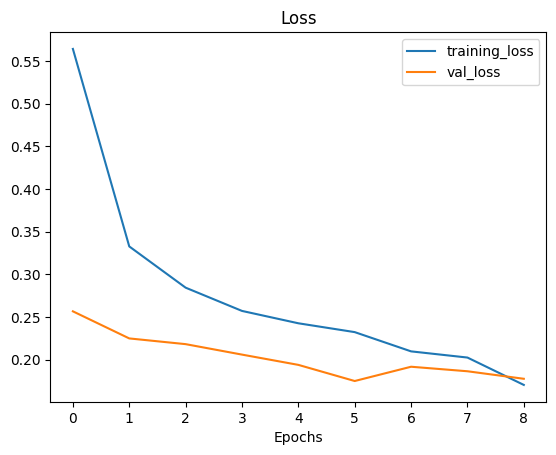

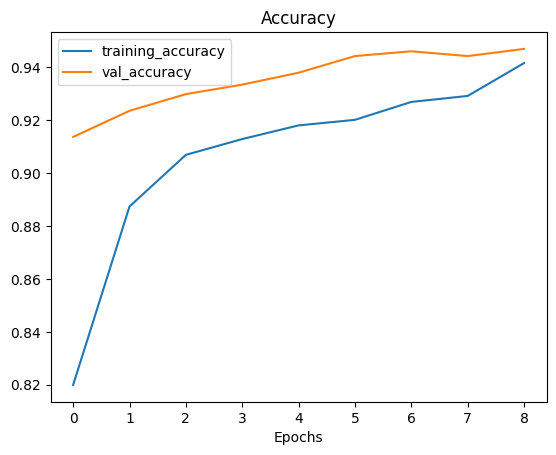

In [60]:
plot_loss_curves(EfficientNetV2M_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

# Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data

In [61]:
test_loss, test_accuracy = EfficientNetV2M_model.evaluate(test_data, verbose=0)

In [62]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.16496
Test Accuracy: 94.65%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics

In [63]:
pred_probs = EfficientNetV2M_model.predict(test_data, verbose=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step


In [64]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [66]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

  biological       0.95      0.97      0.96        99
   cardboard       0.96      0.96      0.96       182
       glass       0.96      0.94      0.95       305
       metal       0.92      0.97      0.95       100
       paper       0.95      0.93      0.94       165
     plastic       0.94      0.93      0.93       192
       trash       0.91      0.95      0.93        78

    accuracy                           0.95      1121
   macro avg       0.94      0.95      0.95      1121
weighted avg       0.95      0.95      0.95      1121



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions

In [67]:
import itertools

In [68]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

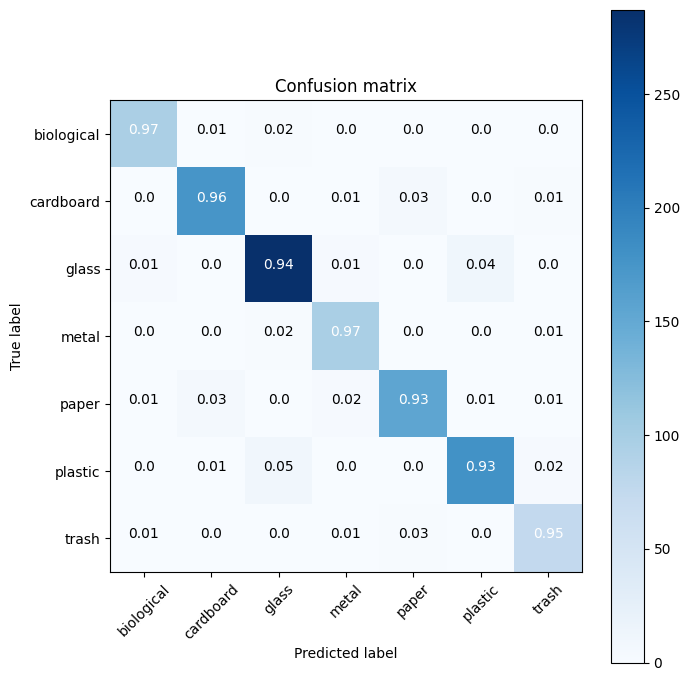

In [69]:
cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions

In [70]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        if i == 1:
            deploy_model_emission_tracker = EmissionsTracker()
            deploy_model_emission_tracker.start()
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            deploy_model_emissions: float = prepare_data_emission_tracker.stop()
            print(f"Deploy Model Carbon Emissions: {deploy_model_emissions} kg")
        else:
            pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0)
            pred_class = class_names[pred_prob.argmax()]

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

[codecarbon WARNING @ 00:09:35] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 00:09:35] [setup] RAM Tracking...
[codecarbon INFO @ 00:09:35] [setup] CPU Tracking...
[codecarbon WARNING @ 00:09:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 00:09:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 00:09:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 00:09:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:09:36] [setup] GPU Tracking...
[codecarbon INFO @ 00:09:36] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:09:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Deploy Model Carbon Emissions: 0.05829501116465553 kg


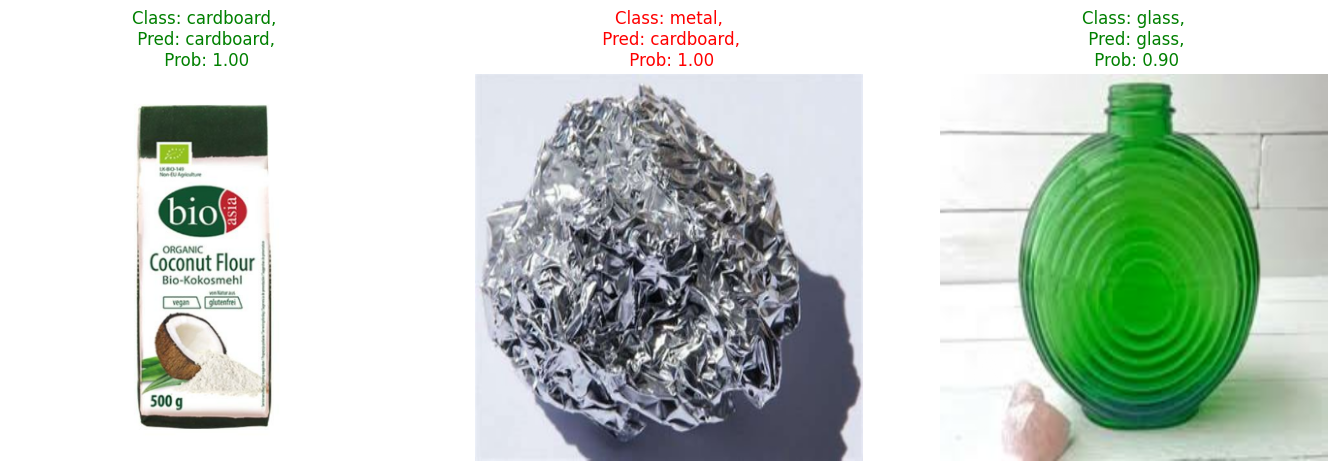

In [71]:
pred_random_images(EfficientNetV2M_model, test_path, class_names)

In [72]:
import pickle
pickle.dump(EfficientNetV2M_model,open("EfficientNetV2M_model.h5","wb"))
# EfficientNetV2M_model.save('EfficientNetV2M_model.h5')

In [73]:
ls ../working

data/                     emissions.csv              logs.zip
EfficientNetV2M.h5        garbage-classification.h5  __notebook__.ipynb
EfficientNetV2M_model.h5  logs/                      runs/
